# Plots with beta

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

def load_function(country, offset=0, mwd="1.0", interval_cps="10.0", f_fem="0.33", f_robust="1.0", len="normal",beta="False"):
        folder="covid_uefa_traces14_robustness"
        fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/{folder}/run"+
            f"-beta={beta}"+
            f"-country={country}"+
            f"-offset_data={offset}"+
            f"-prior_delay=-1"+
            f"-median_width_delay={mwd}"+
            f"-interval_cps={interval_cps}"+
            f"-f_fem={f_fem}"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if not f_robust == "1.0":
            fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
                f"-beta={beta}"+
                f"-country={country}"+
                f"-offset_data={offset}"+
                f"-prior_delay=-1"+
                f"-median_width_delay={mwd}"+
                f"-interval_cps={interval_cps}"+
                f"-f_fem={f_fem}"+
                f"-len=normal"+
                f"-abs_sine=False"+
                f"-t={tune}"+
                f"-d={draws}"+
                f"-max_treedepth={max_treedepth}.pkl")
        model = None
        
        if country == "Spain":
            folder="covid_uefa_traces14_spain"
        else:
            folder="covid_uefa_traces14"
        tune, draws, max_treedepth = (4000, 8000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        tune, draws, max_treedepth = (2000, 4000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        tune, draws, max_treedepth = (500, 1000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
            
        
        tune, draws, max_treedepth = (1000, 2000, 12)
        folder="covid_uefa_traces15"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        tune, draws, max_treedepth = (500, 1000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        
        if model is None: 
            print(fstr(tune, draws, max_treedepth, folder), " not found")
            return None, None
        
        # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
        mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
        trace.posterior = trace.posterior.sel(chain=~mask)
        return model, trace

In [5]:
countries = ['England', 'Scotland', 'Spain', 'Germany', 'Italy', "Netherlands"]

traces, models, dls = [], [], []
for country in tqdm(countries):
    model,trace = load_function(country, beta= "True")
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)    

  0%|          | 0/6 [00:00<?, ?it/s]

Use 4000 sample runs for England with 0 offset
Use 1000 sample runs for Scotland with 0 offset
Use 4000 sample runs for Spain with 0 offset
Use 4000 sample runs for Germany with 0 offset
Use 4000 sample runs for Italy with 0 offset
Use 4000 sample runs for Netherlands with 0 offset


[0 4 1 2 5 3]
Country	50.0	2.5	97.5	16	84	>0
England0	11.045199946466091	5.4207894644517305	19.38900977038018	6.6813766800357	15.604887556165494	1.0
Scotland1	5.327180052739087	-0.07734901697783636	23.948316908816114	1.8591239220851155	9.950044711111218	0.9715
Spain2	4.1100875116439015	-3.1920955392684833	11.35704183182451	1.034063956231785	7.468812401496813	0.9005
Germany3	0.6722260782364065	-6.7515684434452705	10.570256803789013	-1.8992931005563853	3.0291117820162237	0.6760625
Italy4	8.029159289922253	-2.628796088088837	19.79850755363883	2.762566439678162	14.121438119309454	0.93675
Netherlands5	0.6821877923790145	-2.7089926043559607	2.9543272504797553	-1.6708153000156423	1.8735248646494642	0.6465
[2 3 5 0 1 4]
Country	50.0	2.5	97.5	16	84	>0
England0	-1.155883997149607	-5.516963803396629	1.6503411099952934	-3.021138384993651	0.19192605156507528	0.19075
Scotland1	-1.787345726183307	-33.68697264965423	4.5559877183114095	-7.352678310656429	-0.008560390027017563	0.159
Spain2	2.37109093670

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1259: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1263: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


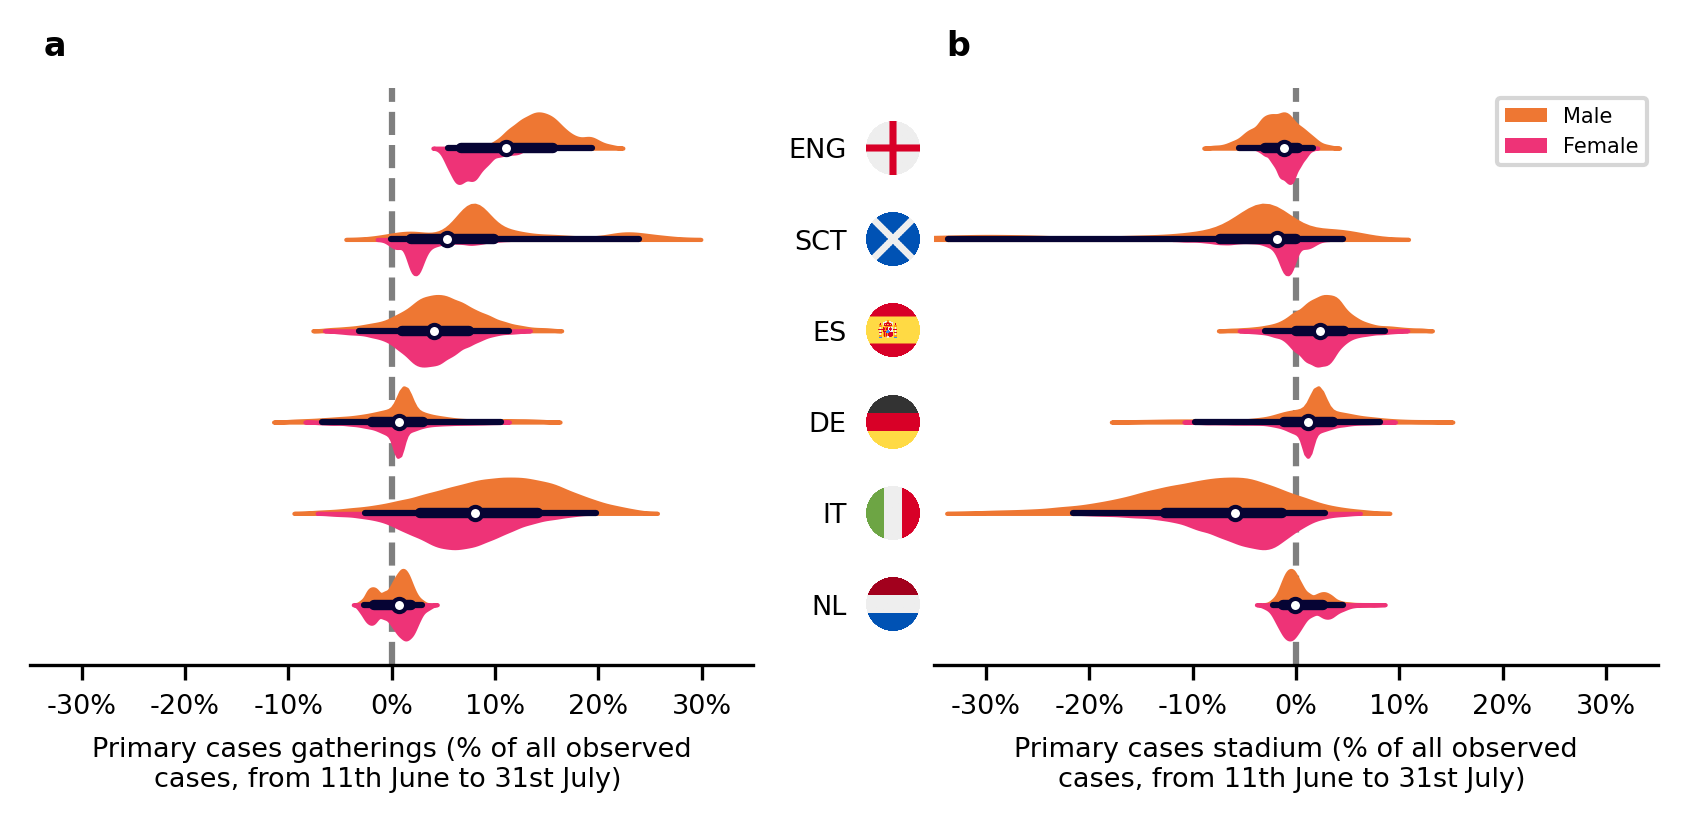

In [6]:
from covid19_soccer.plot.other import soccer_related_cases_overview, legend
import string


# Create figures
fig, axes  = plt.subplots(1, 2,figsize=(7,2.5),gridspec_kw={"wspace":0.25})


# None soccer
soccer_related_cases_overview(
    axes[0],
    traces,
    models,
    dls,
    vertical=True,
    plot_flags=False,
    remove_outliers=True,
    country_order=[0,1,2,3,4,5],
)
axes[0].set_xlim(-35,35)
axes[0].set_xlabel("Primary cases gatherings (% of all observed\ncases, from 11th June to 31st July) ")
axes[0].set(yticklabels=[])
axes[0].tick_params(left=False)

# Soccer
soccer_related_cases_overview(
    axes[1],
    traces,
    models,
    dls,
    plot_betas=True,
    vertical=True,
    plot_flags=True,
    ypos_flags=-35,
    flags_zoom=0.025,
    country_order=[0,1,2,3,4,5],
)
axes[1].set_xlim(-35,35)
axes[1].set_xlabel("Primary cases stadium (% of all observed\ncases, from 11th June to 31st July) ")

# Add legend
legend(axes[1],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc=1
)

#Add axes annotations
alphabet_string = list(string.ascii_lowercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')


plt.show()
fig_path = "../../figures/SI"
fig.savefig(f"{fig_path}/beta.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/beta.png", **save_kwargs)
plt.close(fig=fig)

In [19]:
plt.close("all")

[0 4 1 2 5 3]
Country	50.0	2.5	97.5	16	84	>0
England0	11.045199946466091	5.4207894644517305	19.38900977038018	6.6813766800357	15.604887556165494	1.0
Scotland1	5.327180052739087	-0.07734901697783636	23.948316908816114	1.8591239220851155	9.950044711111218	0.9715
Spain2	4.1100875116439015	-3.1920955392684833	11.35704183182451	1.034063956231785	7.468812401496813	0.9005
Germany3	0.6722260782364065	-6.7515684434452705	10.570256803789013	-1.8992931005563853	3.0291117820162237	0.6760625
Italy4	8.029159289922253	-2.628796088088837	19.79850755363883	2.762566439678162	14.121438119309454	0.93675
Netherlands5	0.6821877923790145	-2.7089926043559607	2.9543272504797553	-1.6708153000156423	1.8735248646494642	0.6465
[2 3 5 0 1 4]
Country	50.0	2.5	97.5	16	84	>0
England0	-1.155883997149607	-5.516963803396629	1.6503411099952934	-3.021138384993651	0.19192605156507528	0.19075
Scotland1	-1.787345726183307	-33.68697264965423	4.5559877183114095	-7.352678310656429	-0.008560390027017563	0.159
Spain2	2.37109093670

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1259: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1263: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


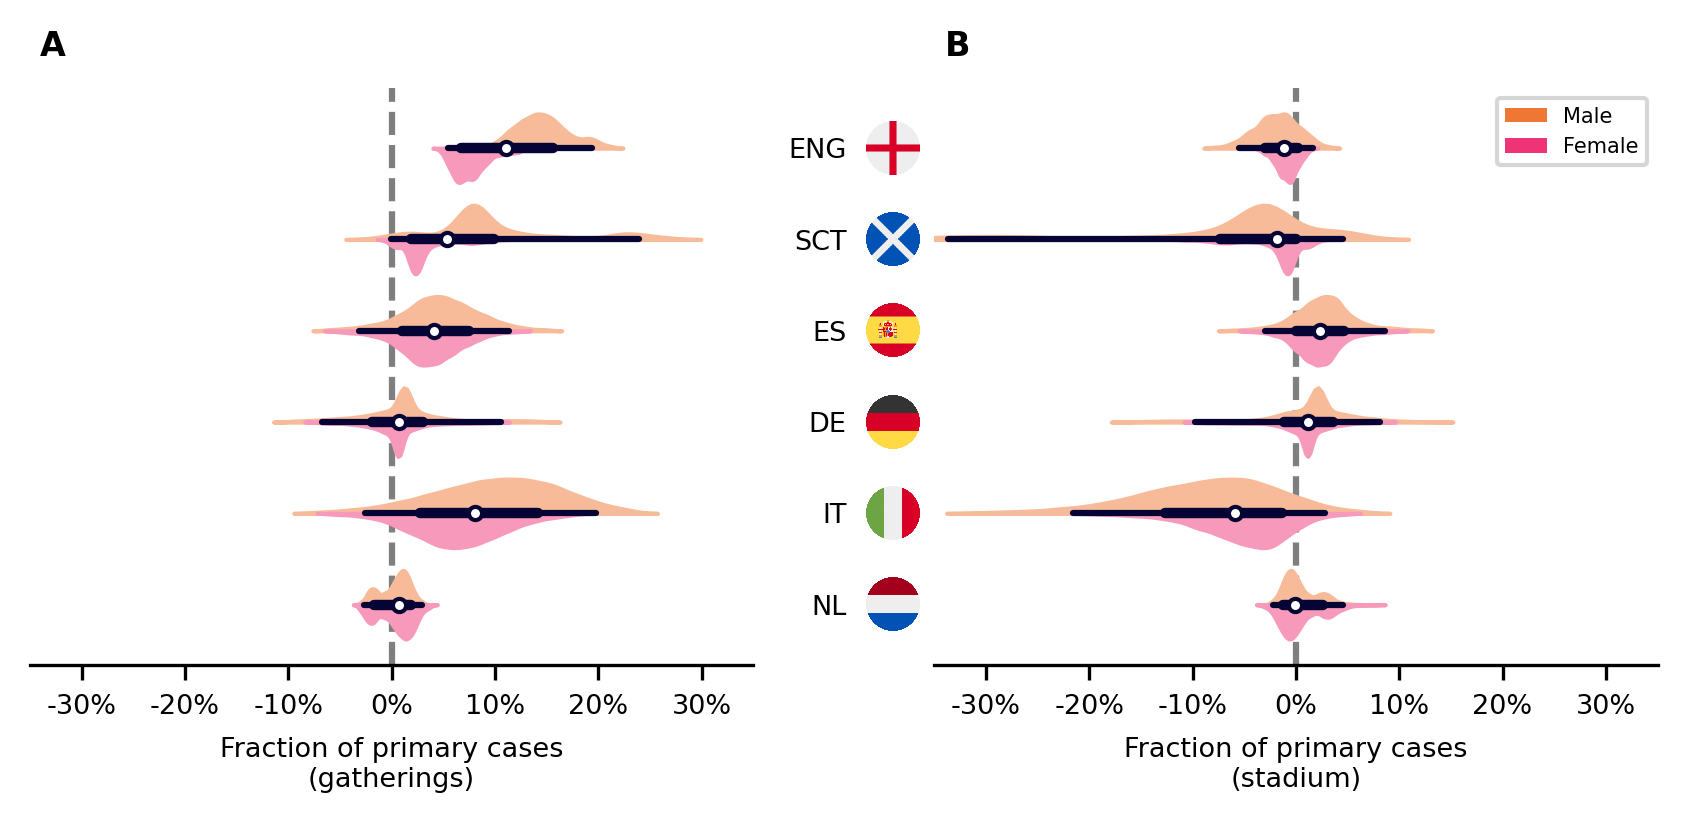

In [7]:
# Plotting
from covid19_soccer.plot.other import soccer_related_cases_overview, legend
import string
from covid19_soccer.plot.rcParams import *
from covid19_soccer.plot.utils import lighten_color
# Adjust colors
color_male = lighten_color(rcParams.color_male,0.5)
color_female = lighten_color(rcParams.color_female,0.5)

fig, axes  = plt.subplots(1, 2,figsize=(7,2.5),gridspec_kw={"wspace":0.25})

soccer_related_cases_overview(
    axes[0],
    traces,
    models,
    dls,
    vertical=True,
    plot_flags=False,
    remove_outliers=True,
    country_order=[0,1,2,3,4,5],
    alpha=0.5,
    colors=[color_male,color_female]
)
axes[0].set_xlim(-35,35)
axes[0].set_xlabel("Fraction of primary cases\n(gatherings)")
axes[0].set(yticklabels=[])
axes[0].tick_params(left=False)

soccer_related_cases_overview(
    axes[1],
    traces,
    models,
    dls,
    plot_betas=True,
    vertical=True,
    plot_flags=True,
    remove_outliers=True,
    ypos_flags=-35,
    flags_zoom=0.025,
    country_order=[0,1,2,3,4,5],
    alpha=0.5,
    colors=[color_male,color_female]
)
axes[1].set_xlim(-35,35)
axes[1].set_xlabel("Fraction of primary cases\n(stadium)")
legend(axes[1],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc=1
)

#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')


plt.show()
fig_path = "../figures/SI"
fig.savefig(f"{fig_path}/beta_l.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/beta_l.png", **save_kwargs)
plt.close(fig=fig)

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded OxCGRT.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/OxCGRT.csv.gz successful.
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1254: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0

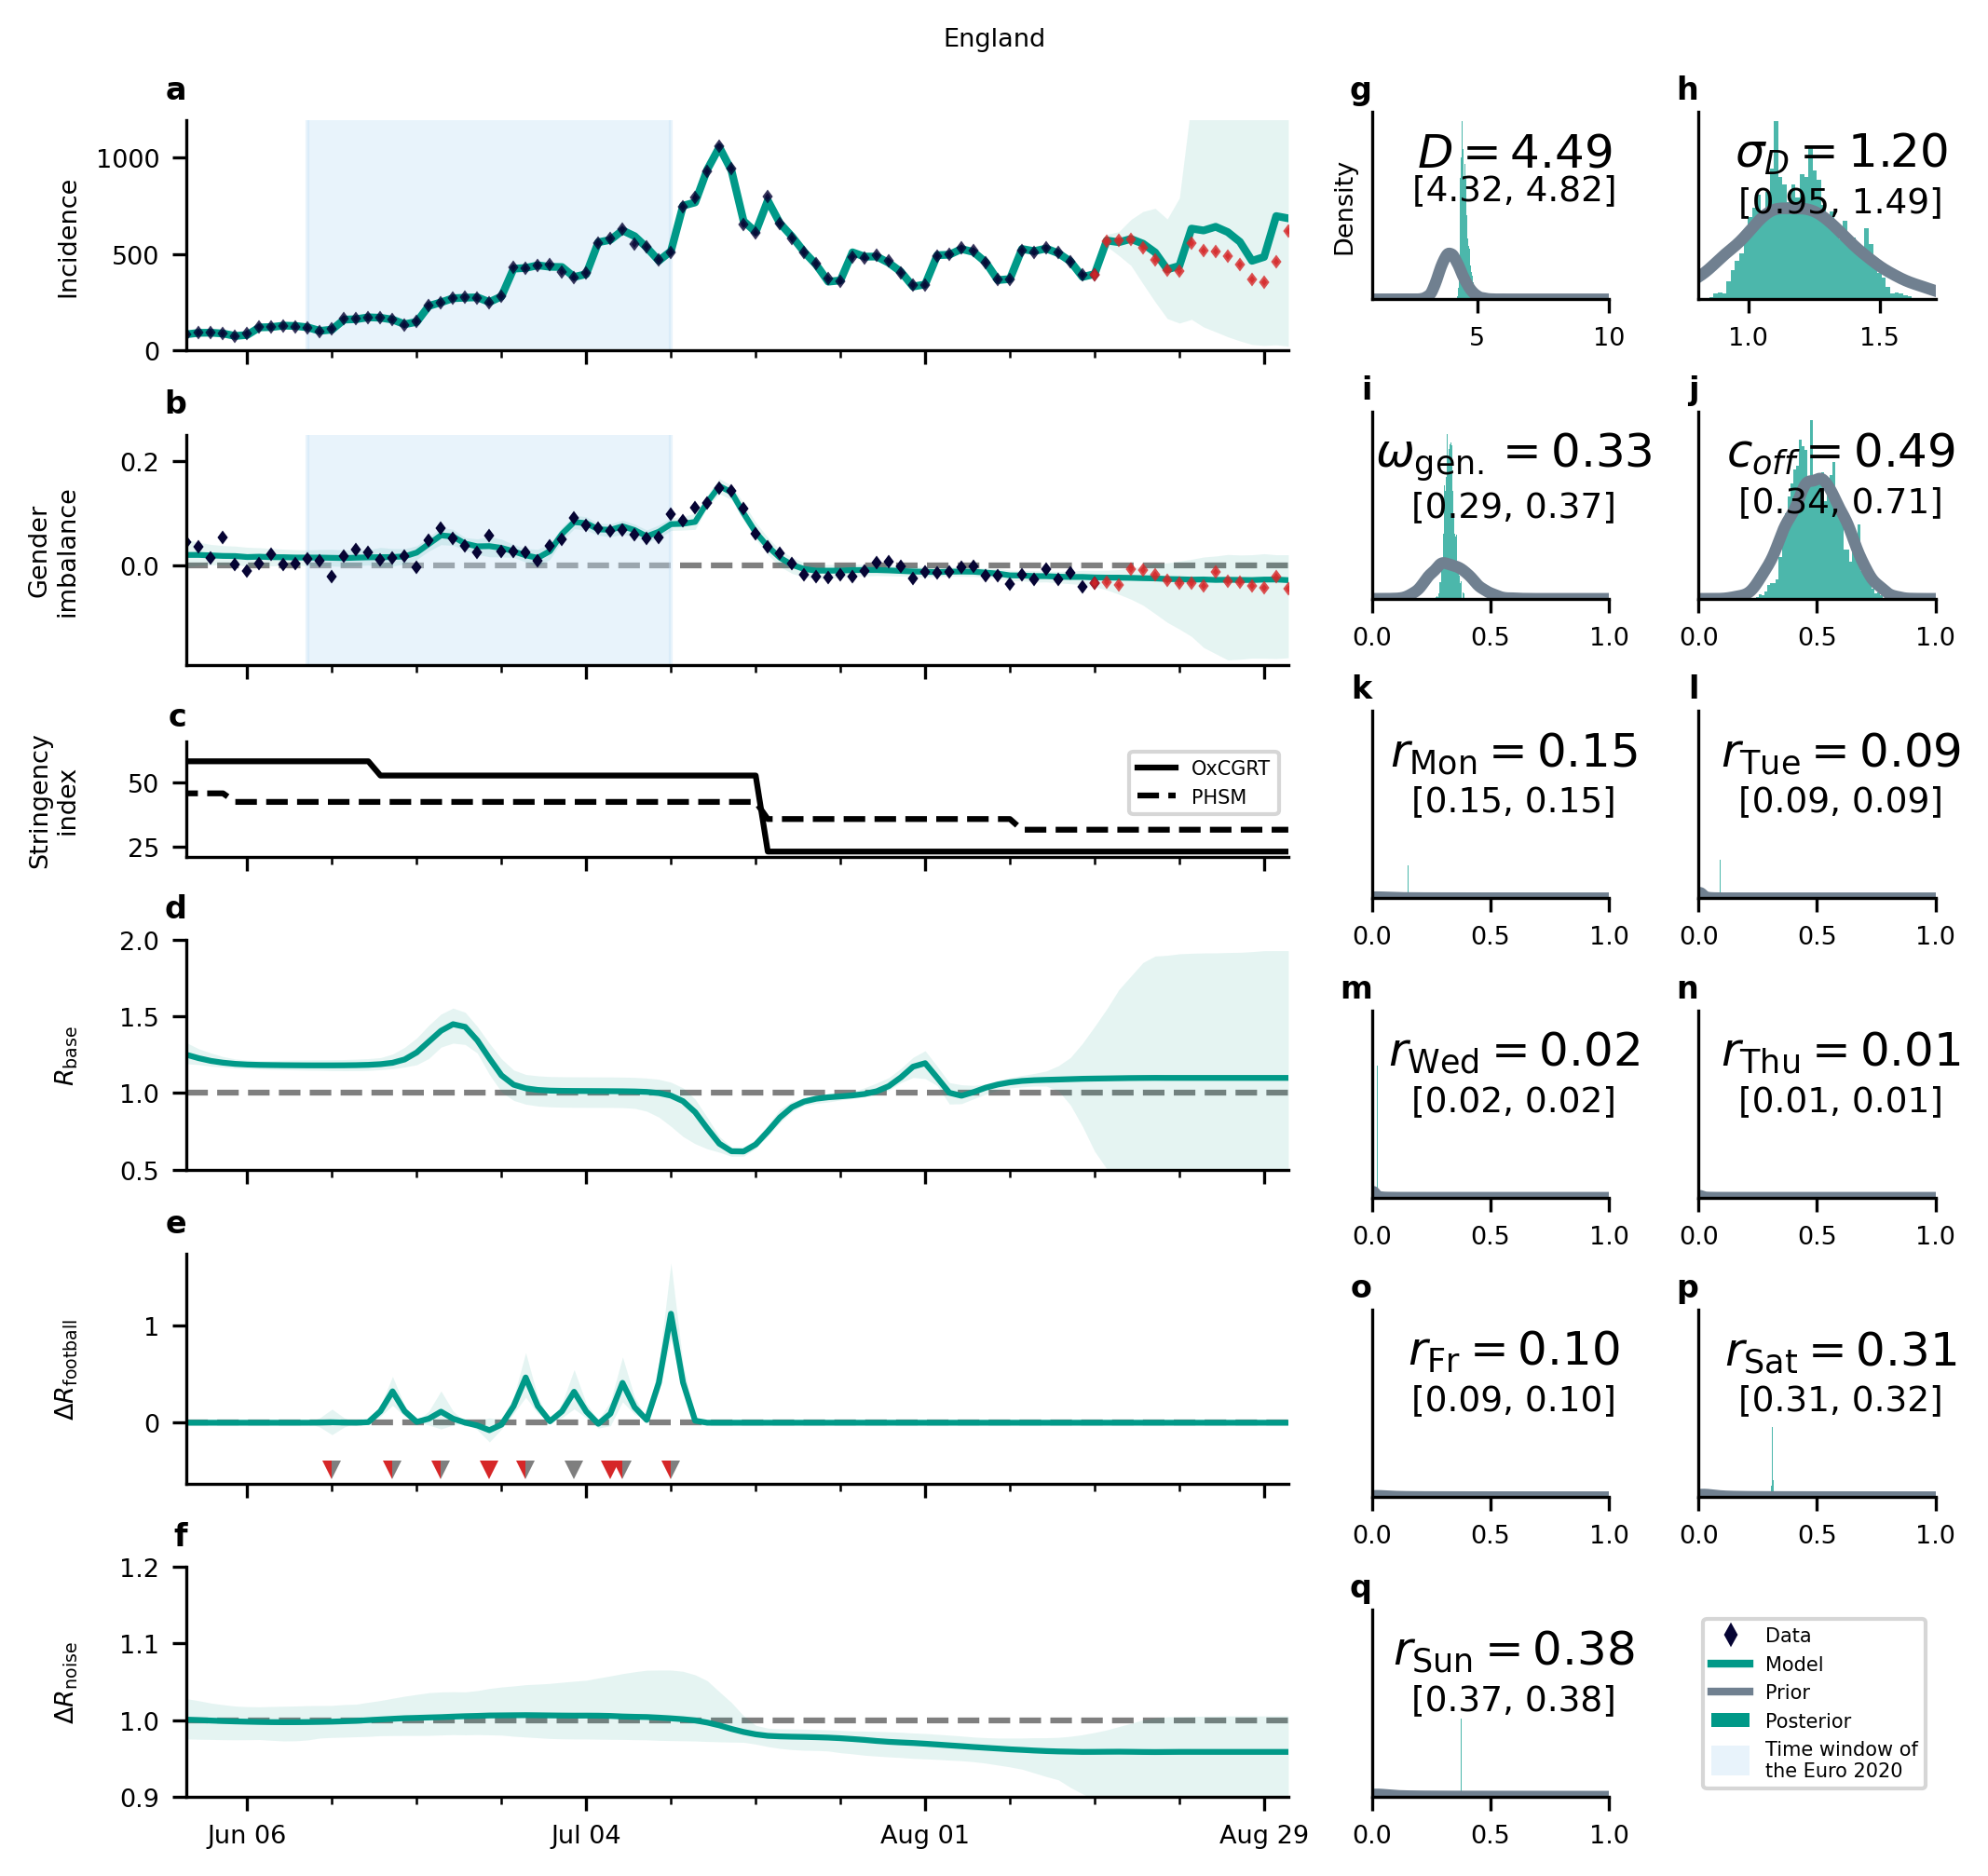

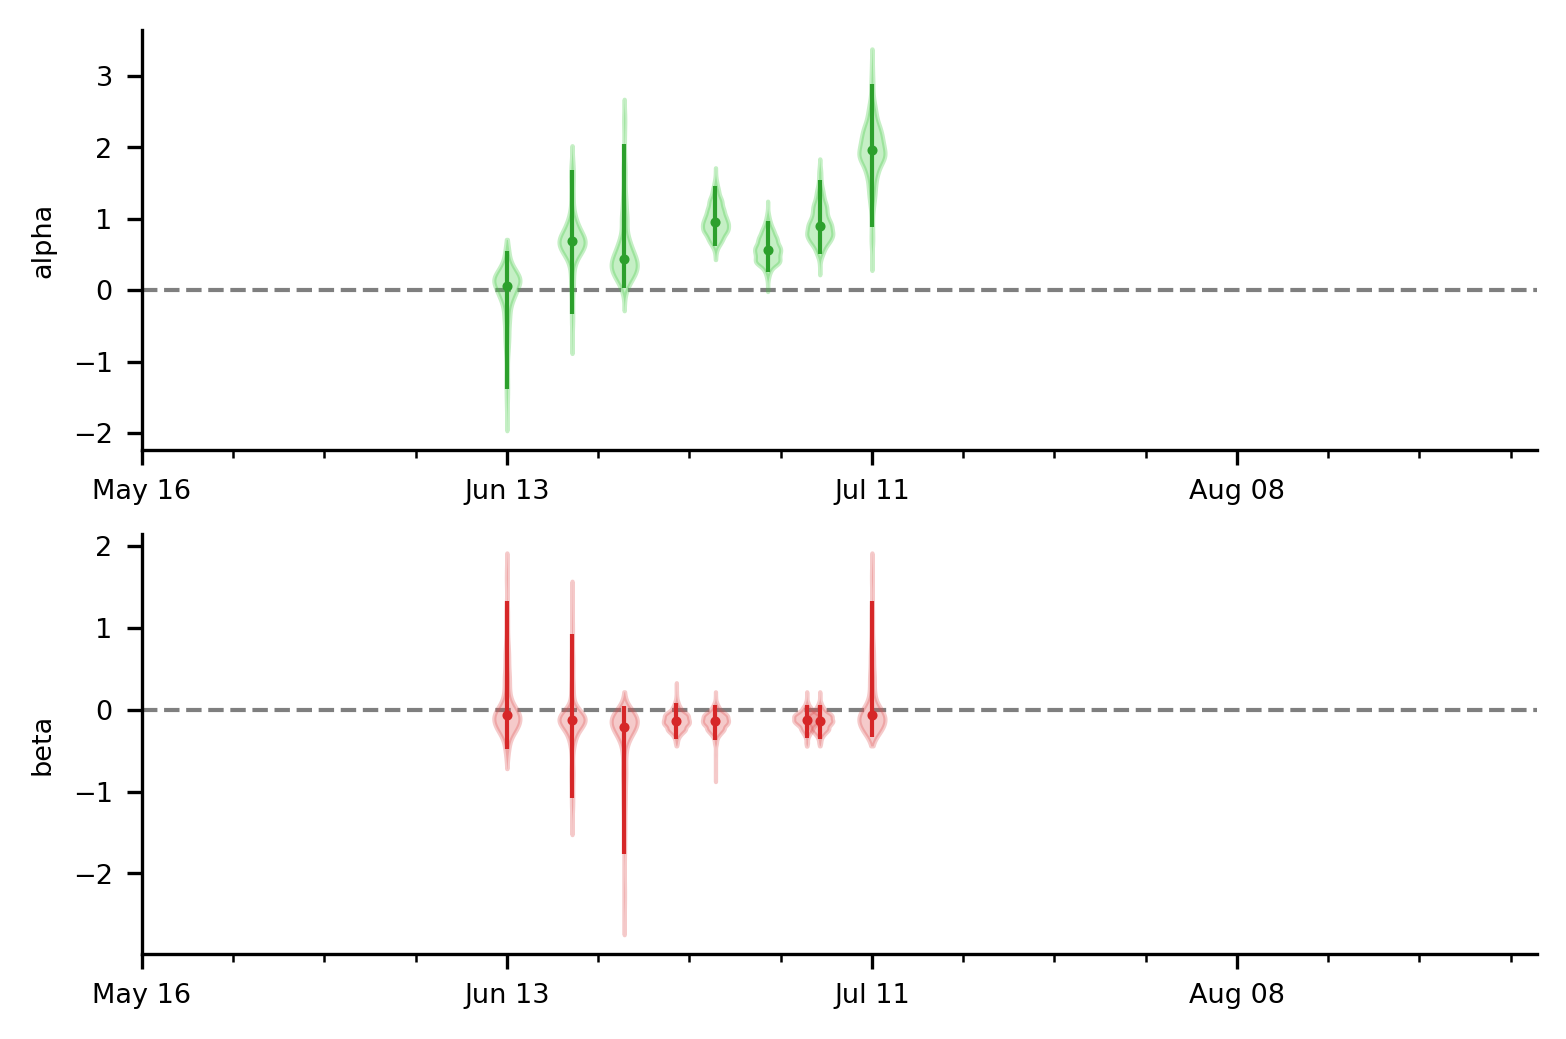

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1254: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


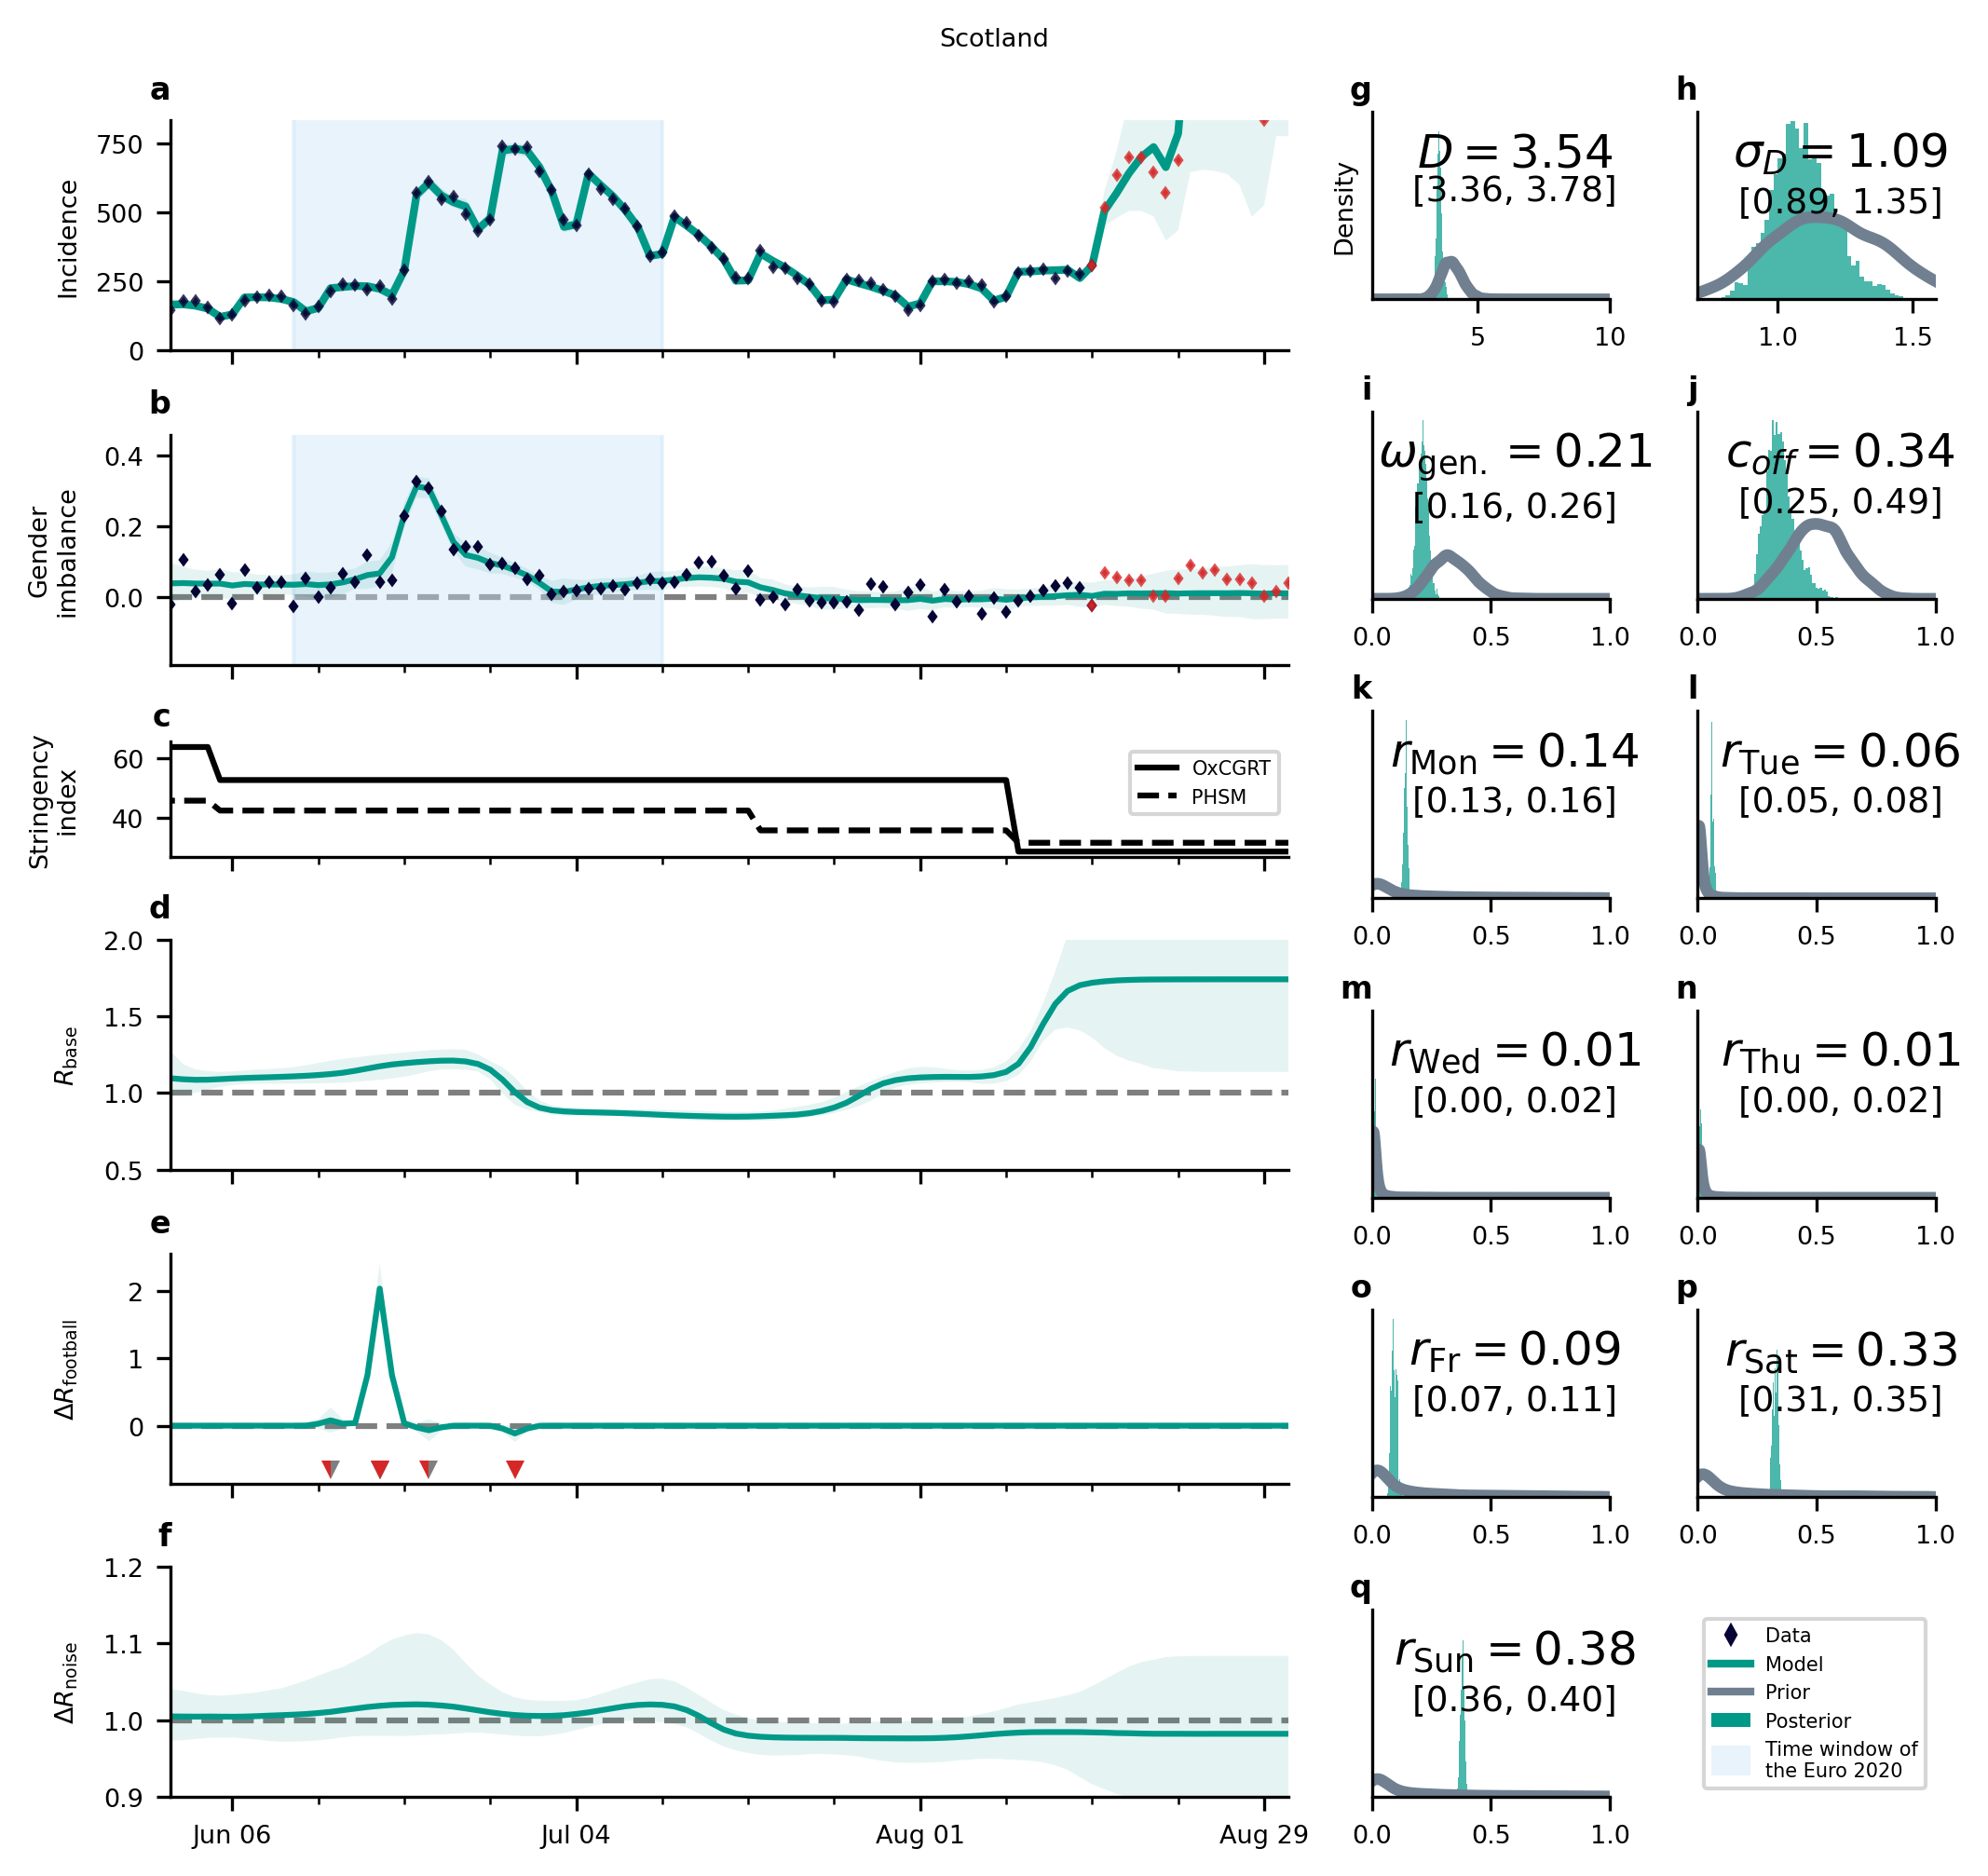

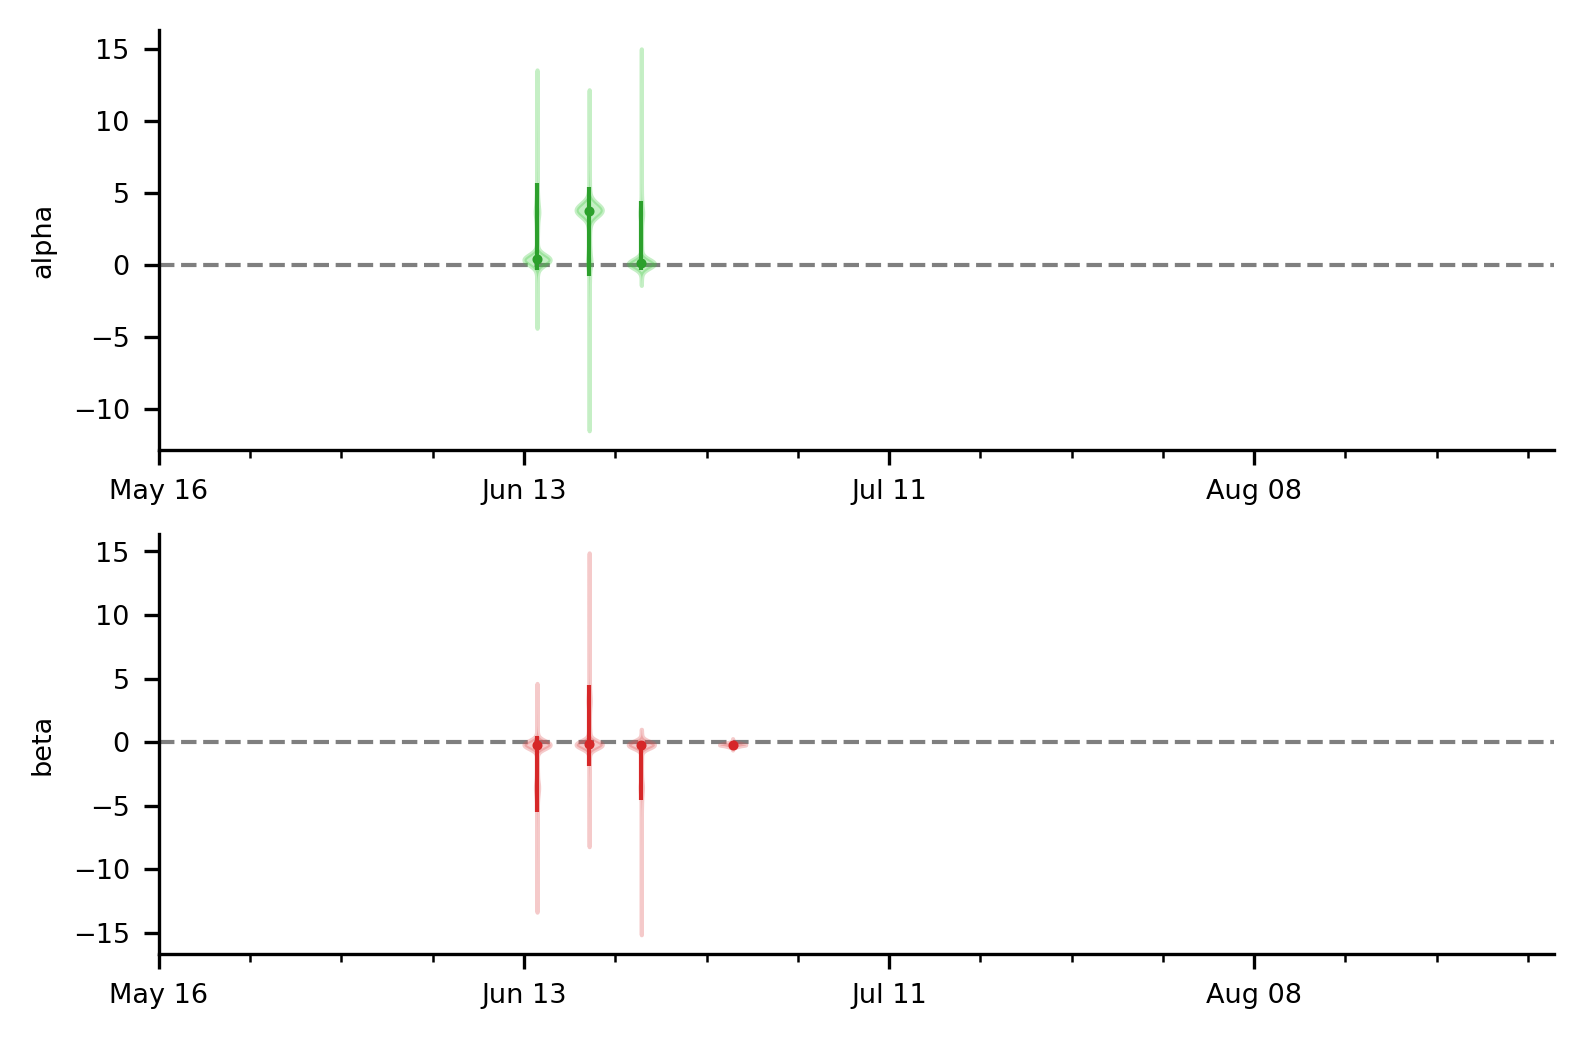

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1254: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


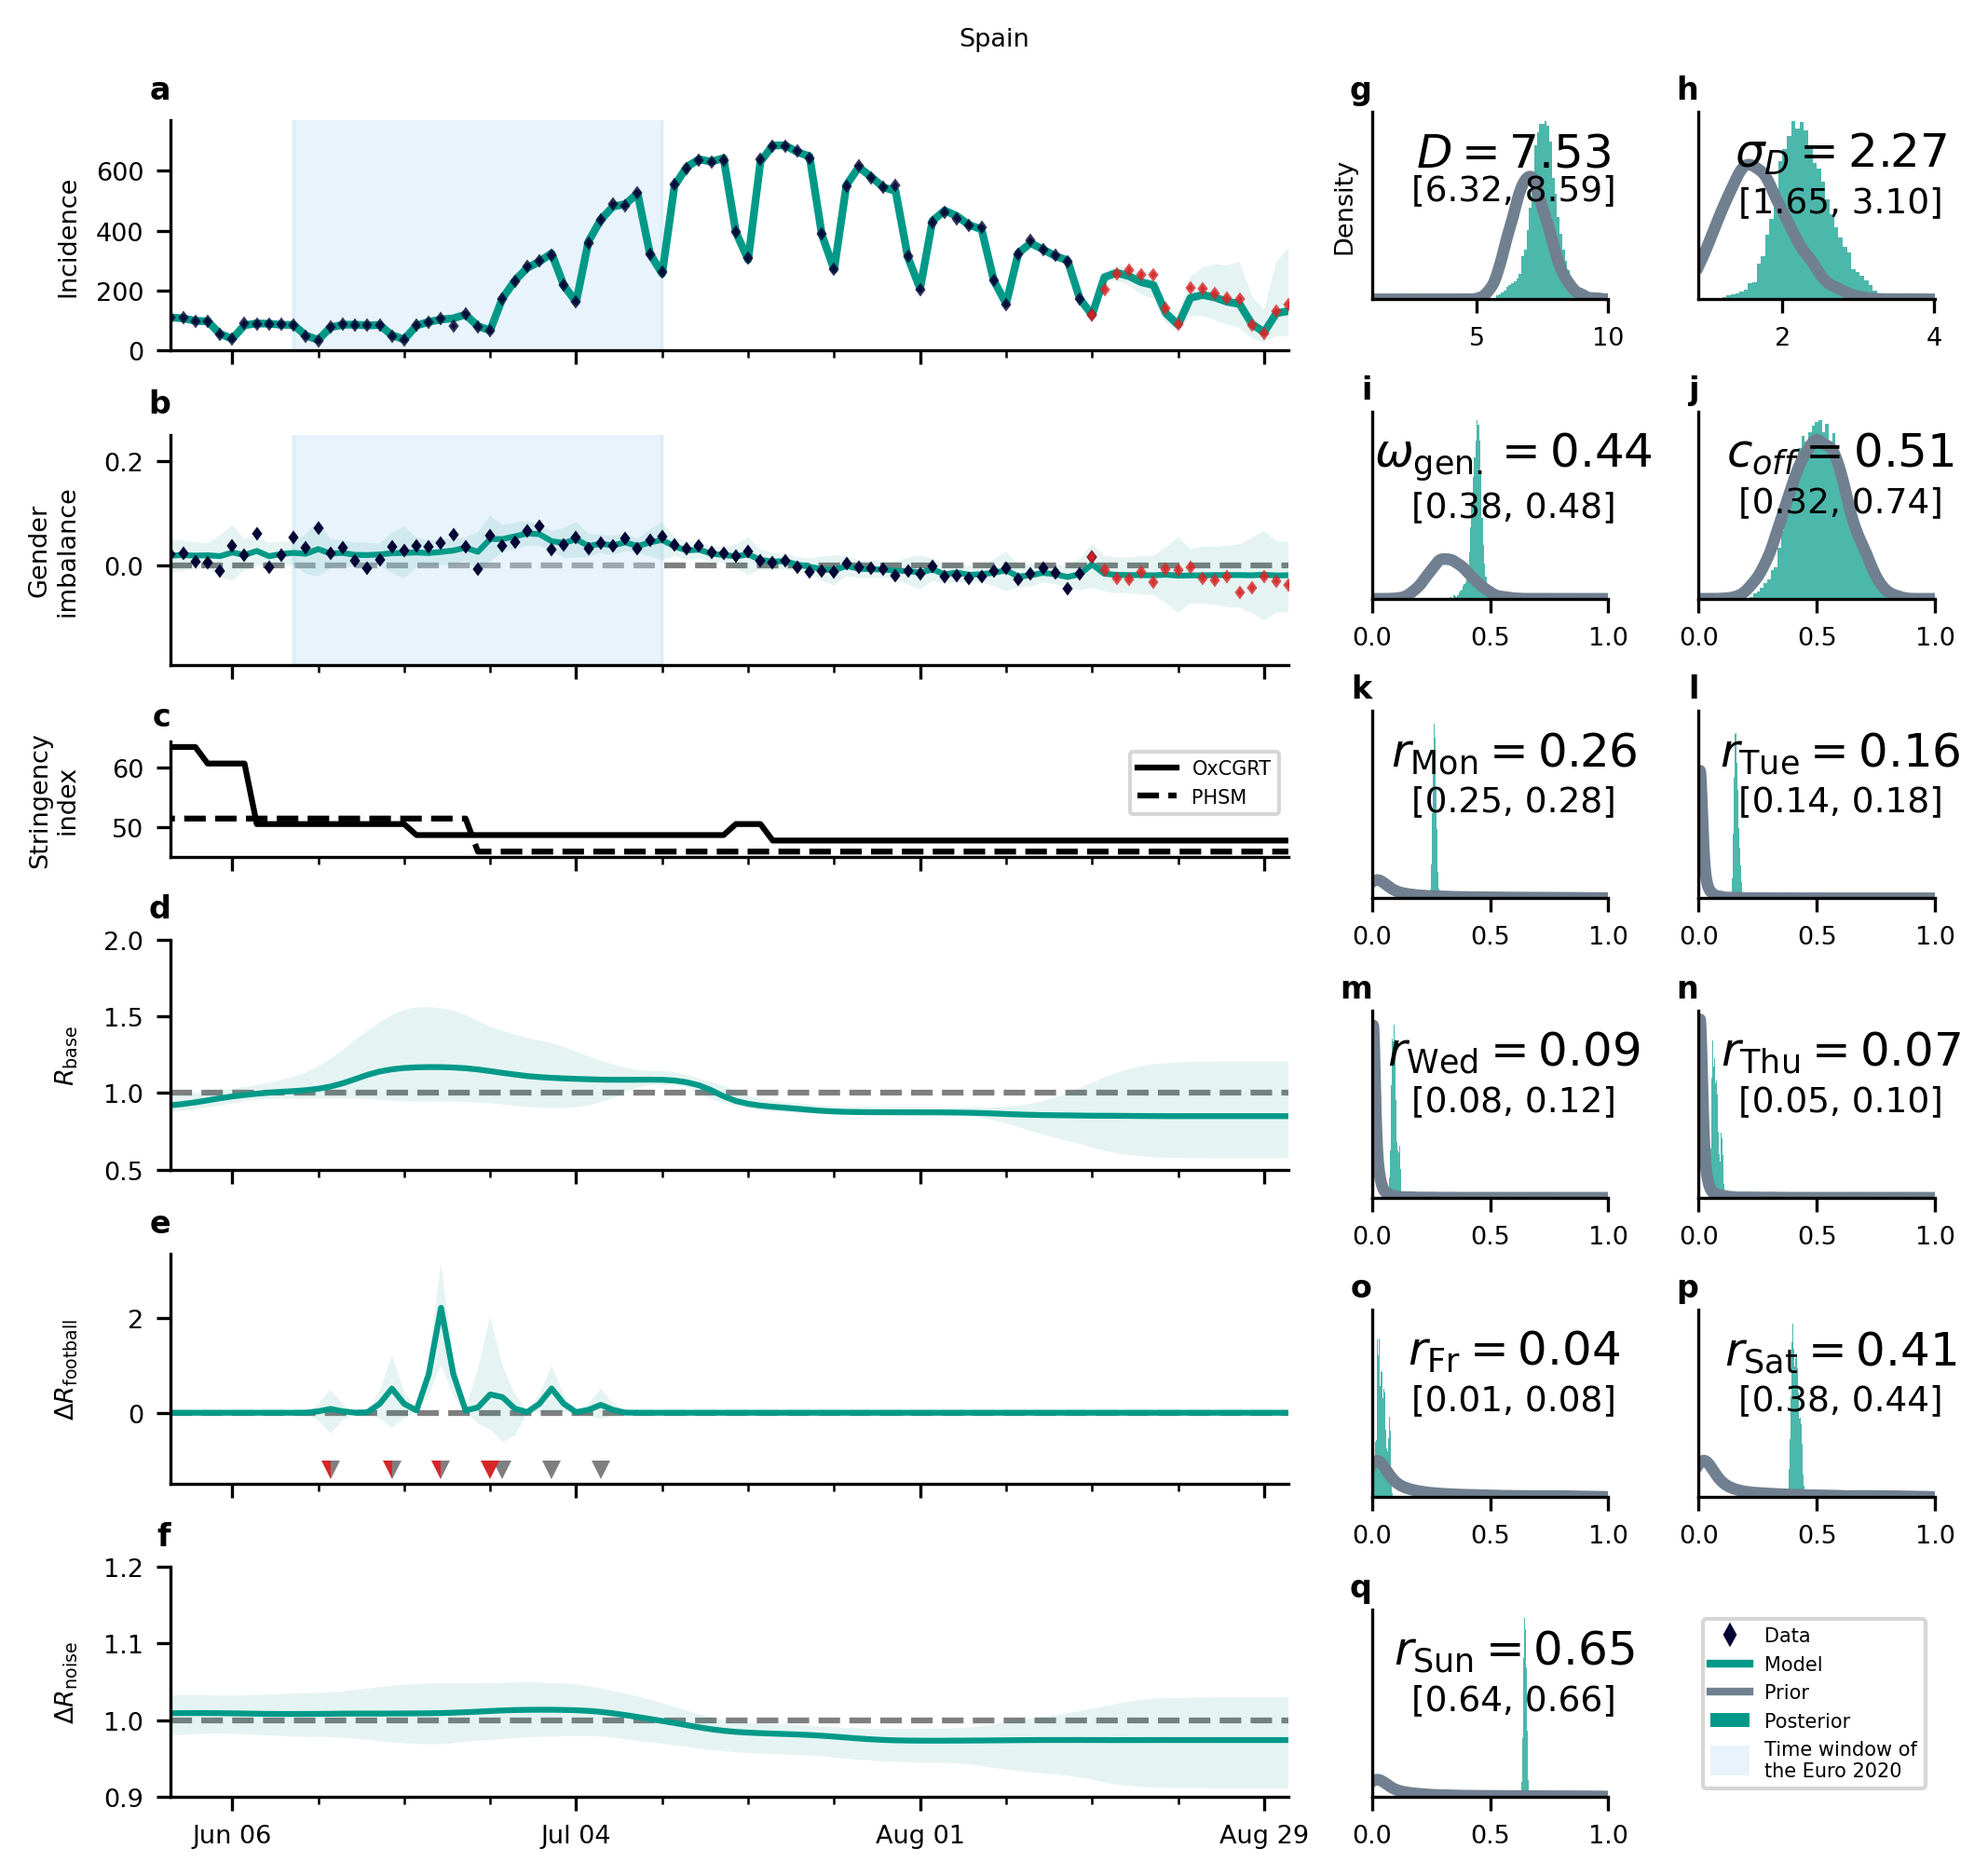

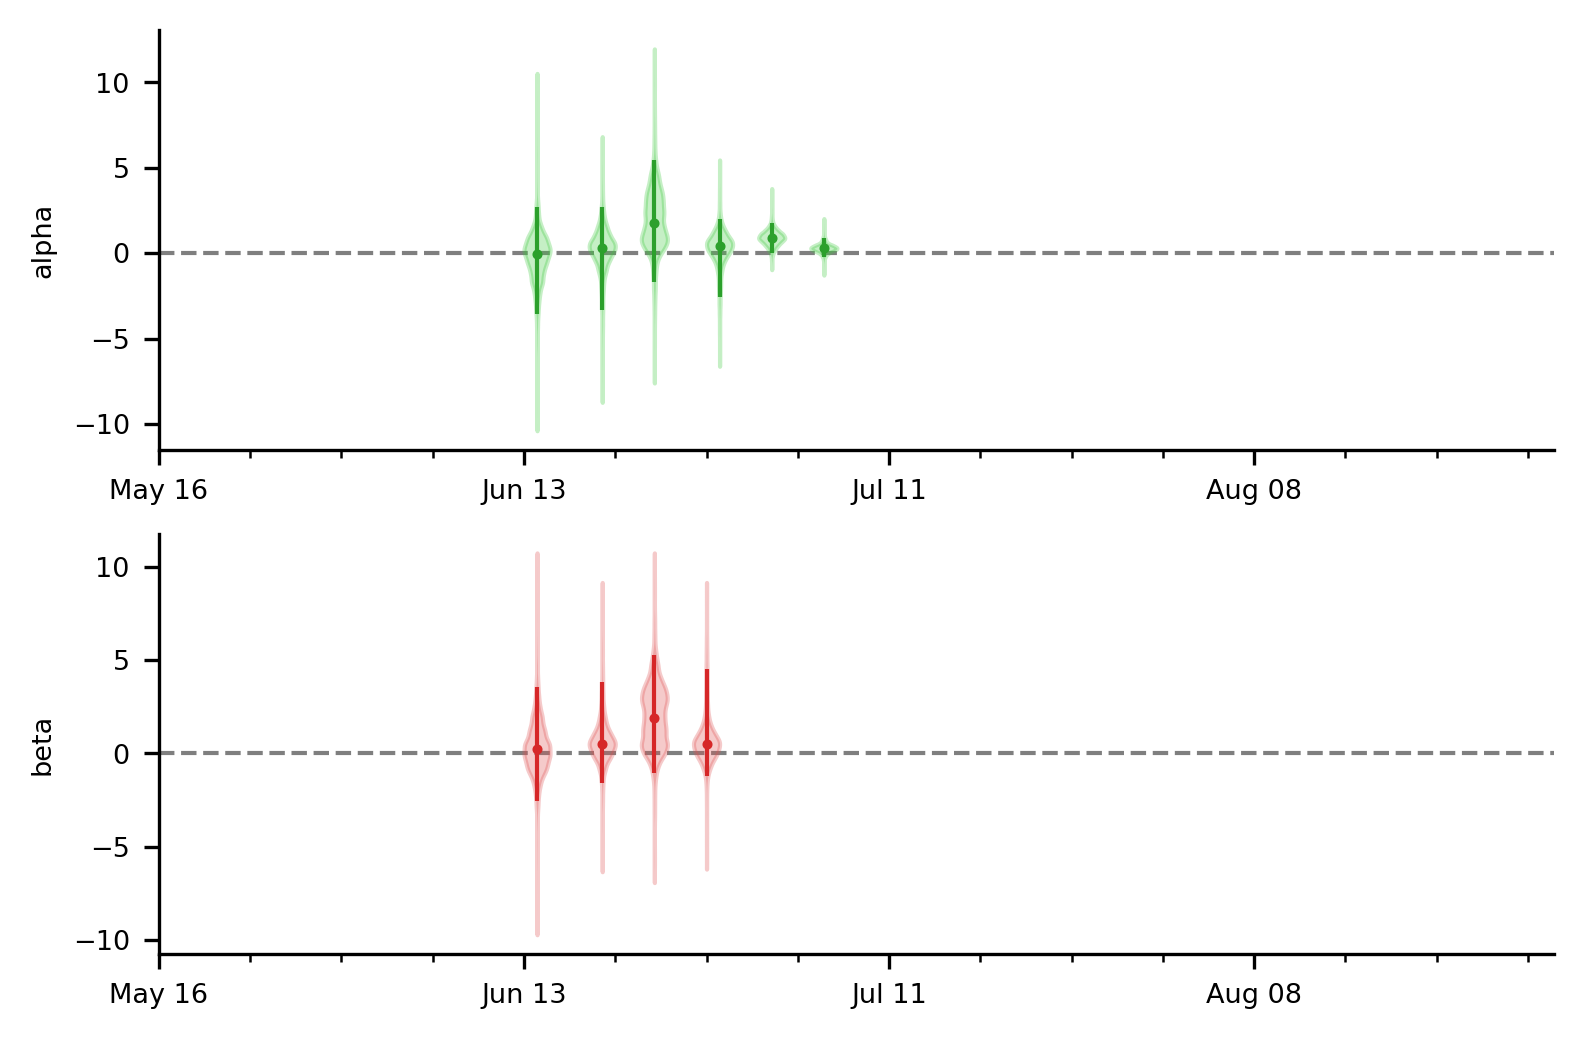

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1254: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


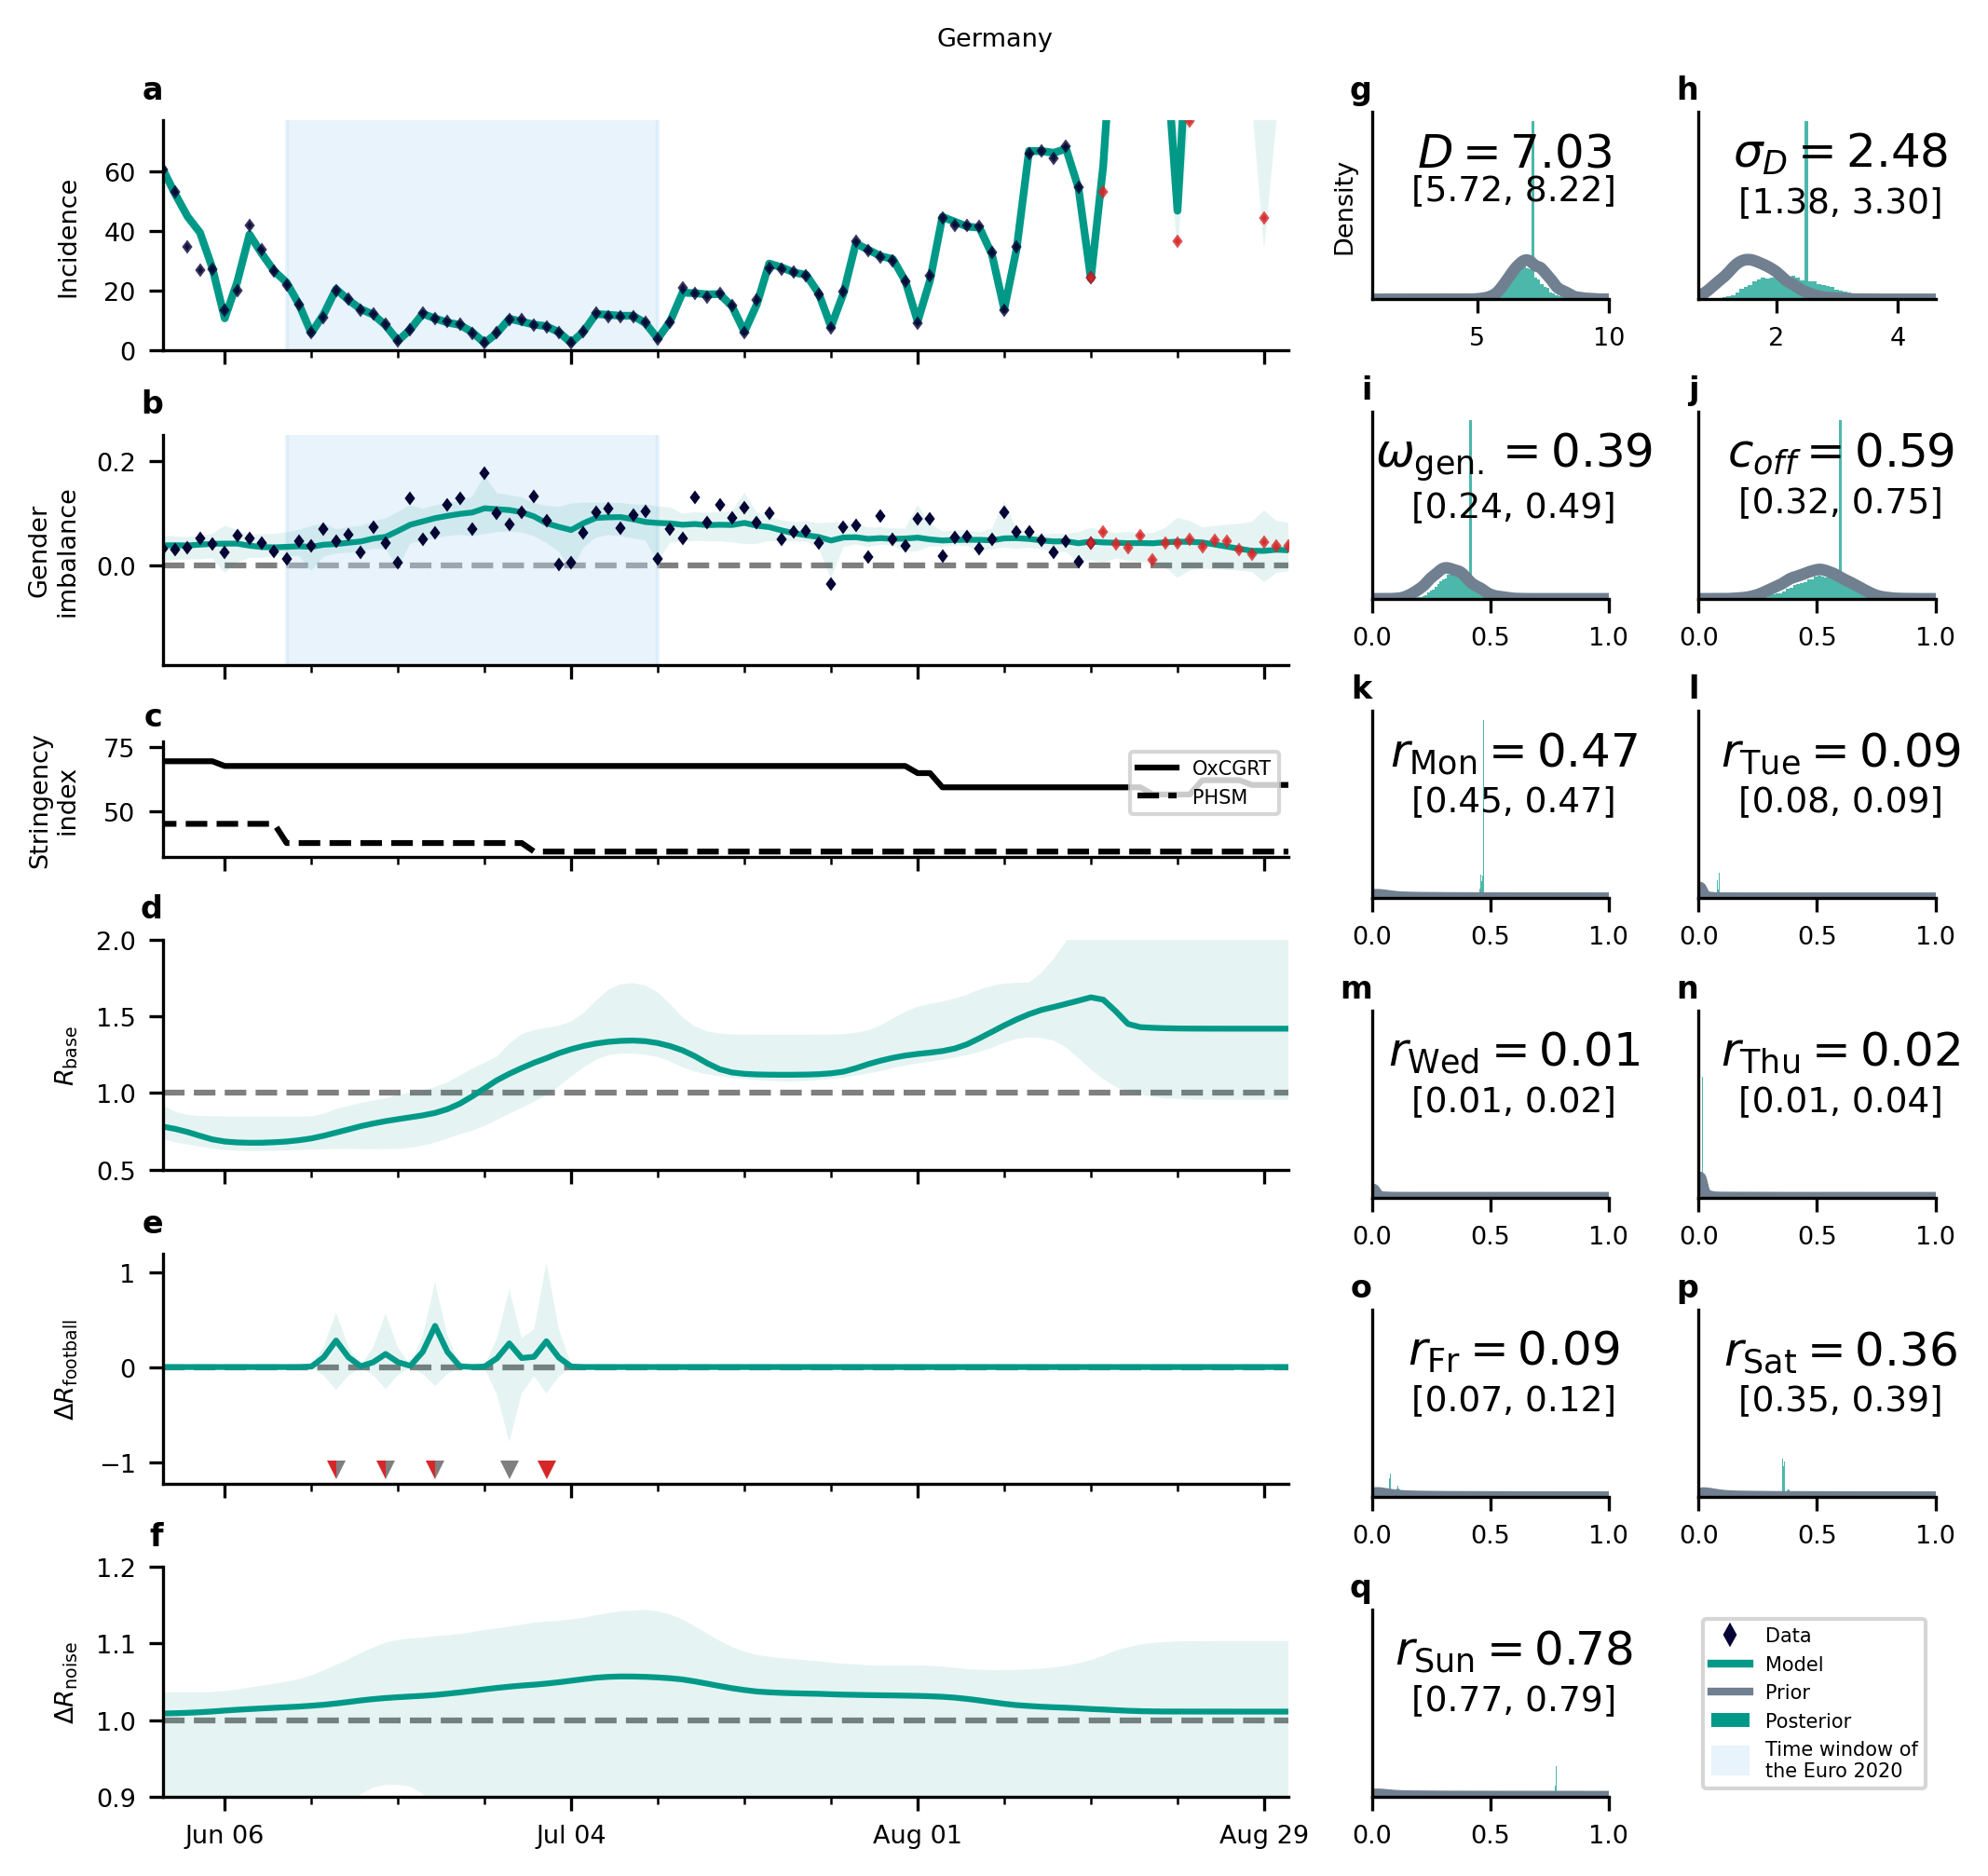

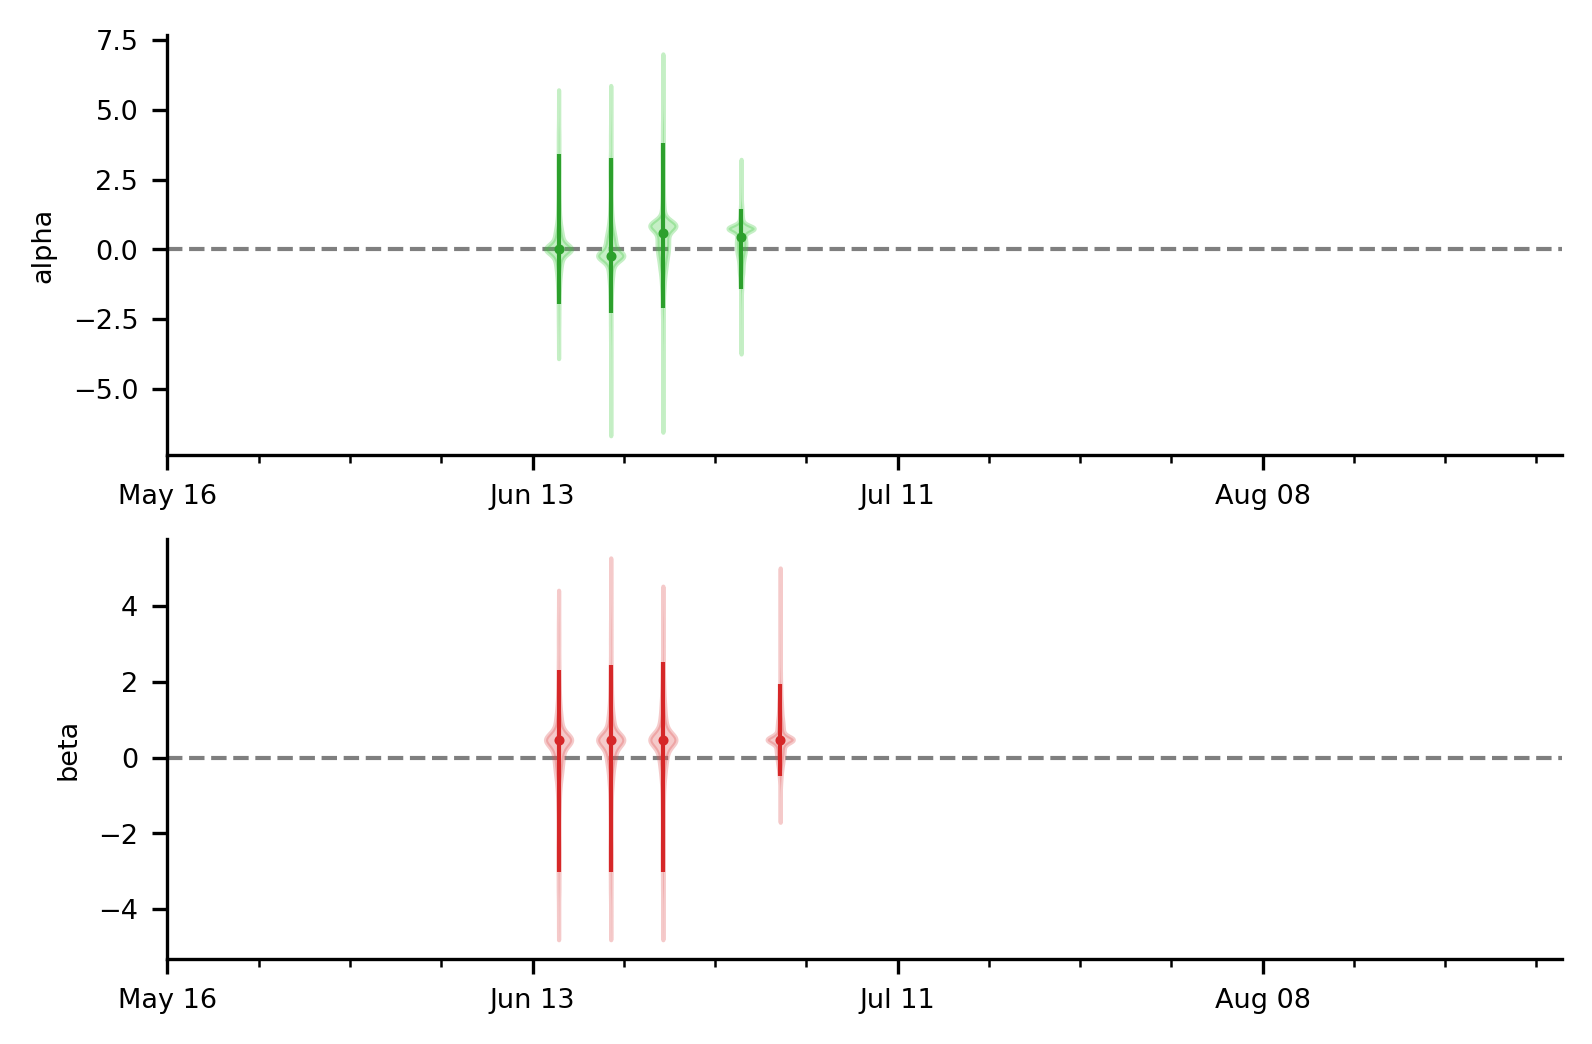

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:157: RuntimeWarning: invalid value encountered in true_divide
  y=(
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/timeseries.py:182: RuntimeWarning: invalid value encountered in true_divide
  imbalance = (
INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1254: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


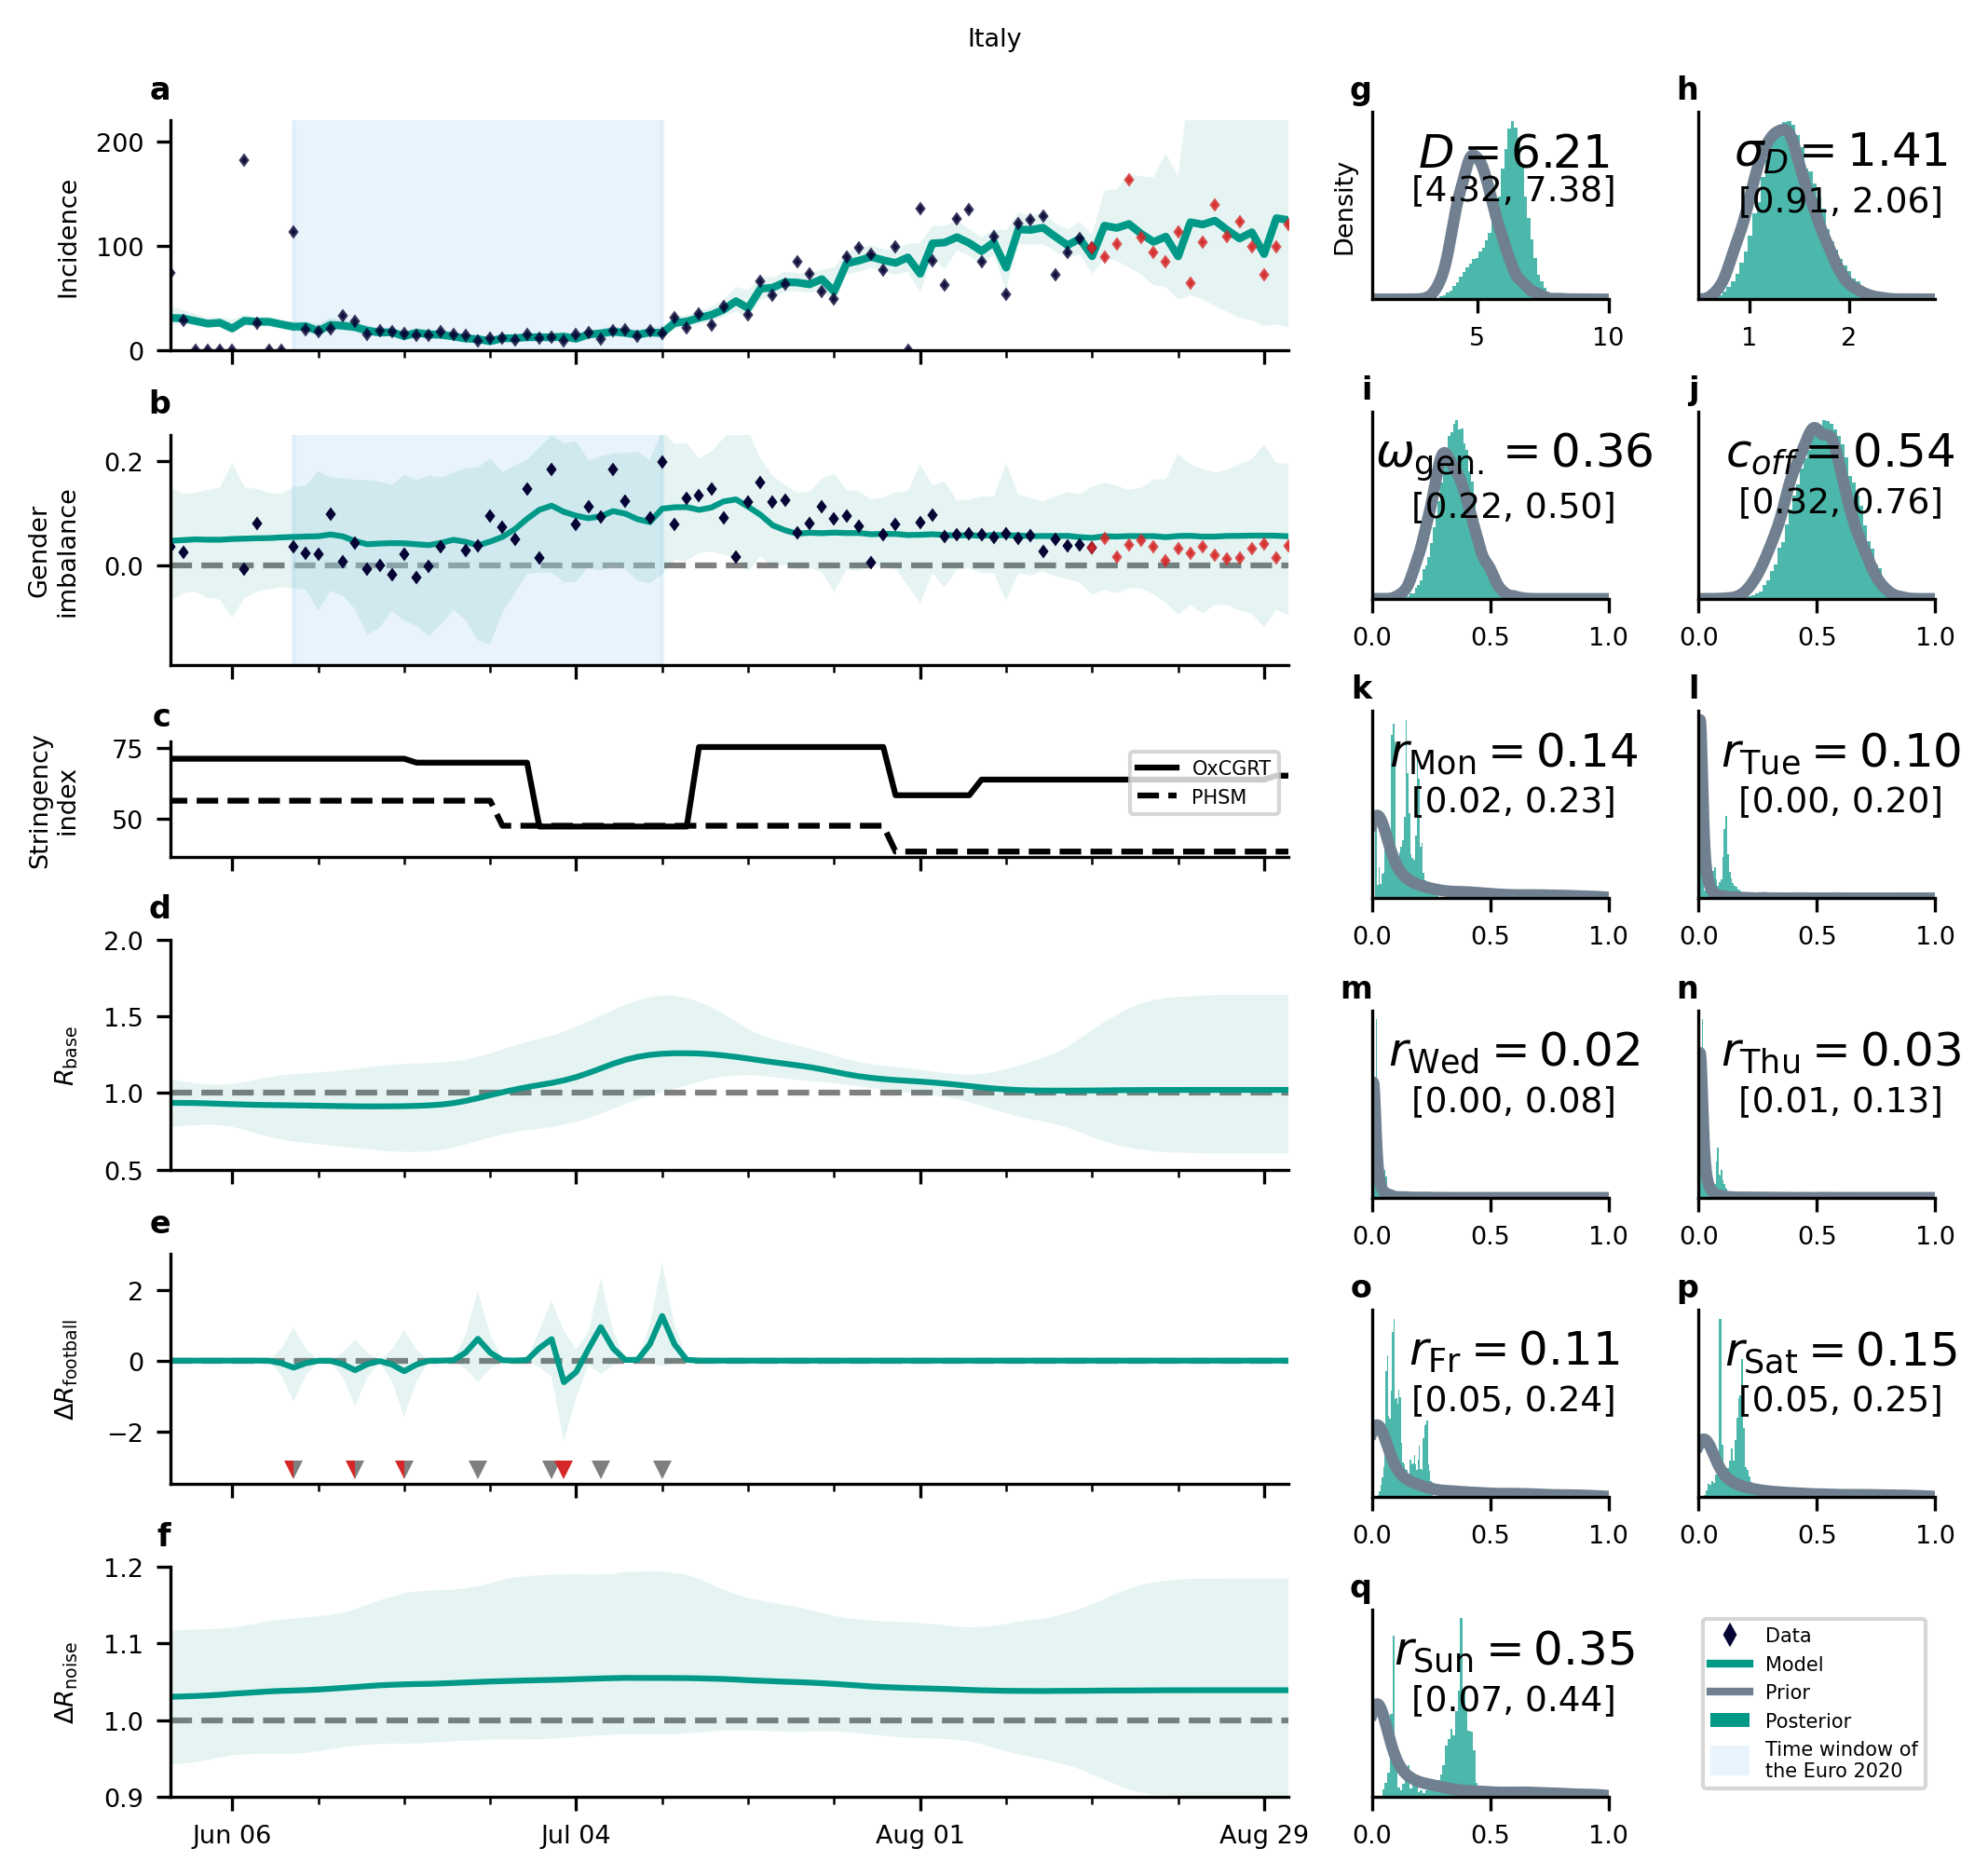

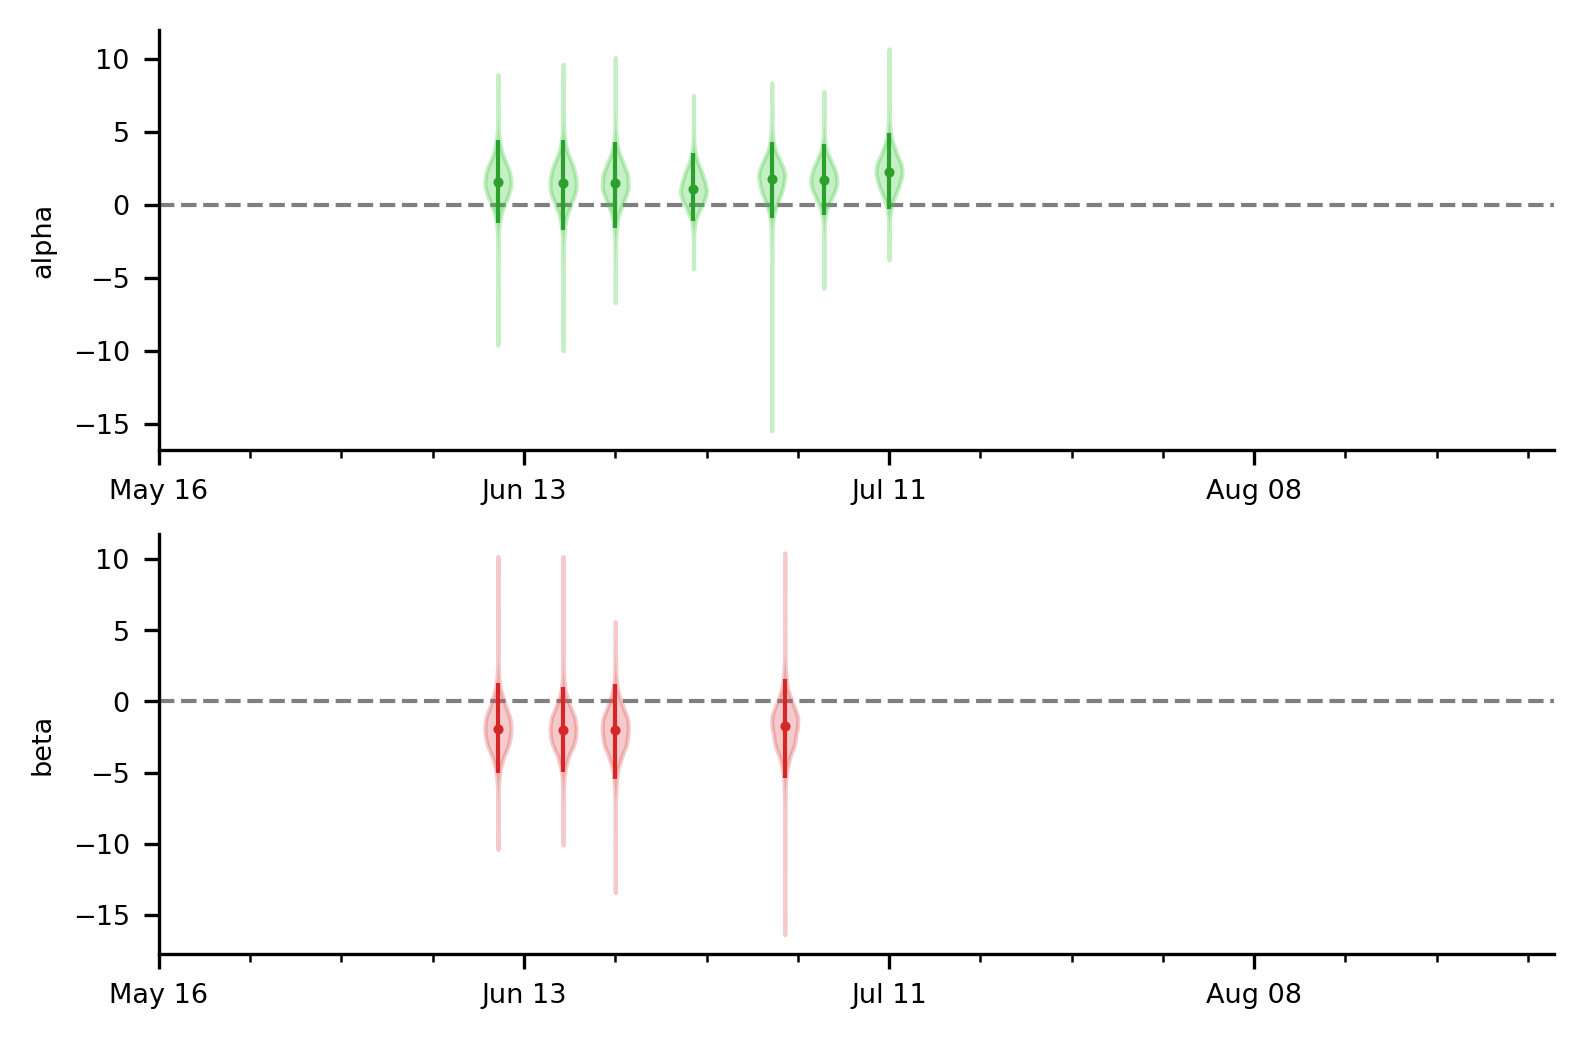

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1254: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_posterior, lw=0,),)


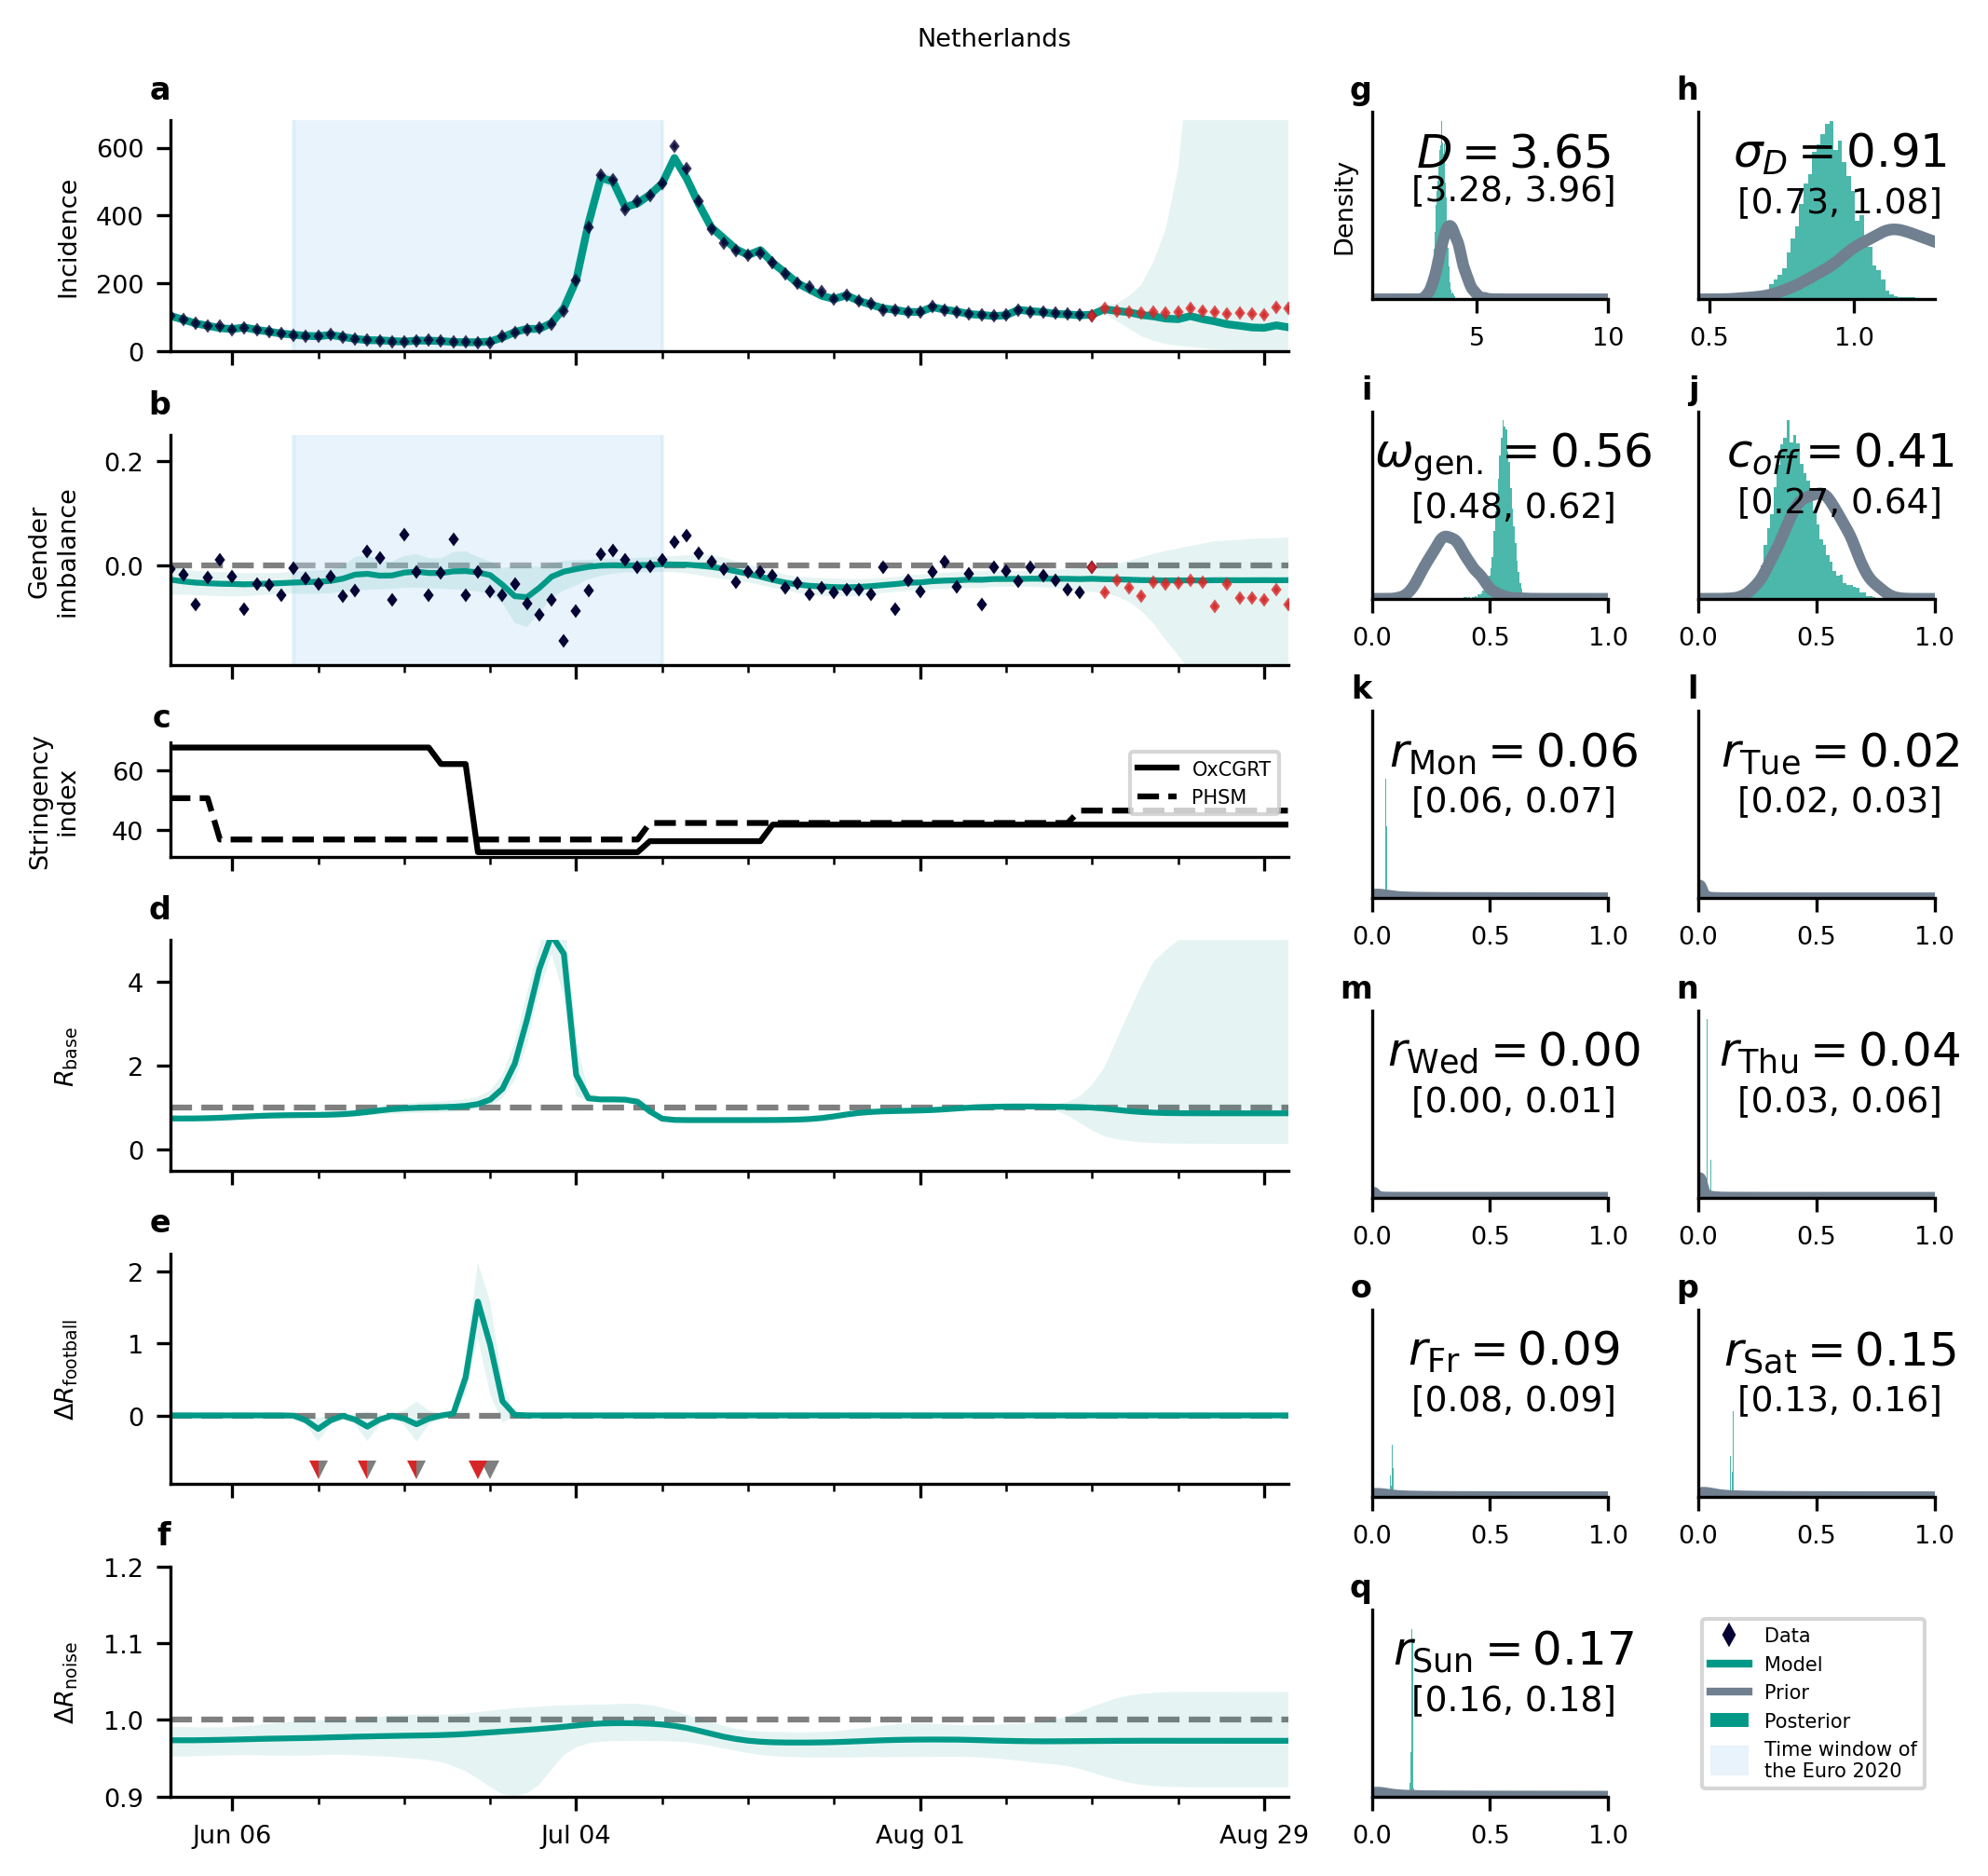

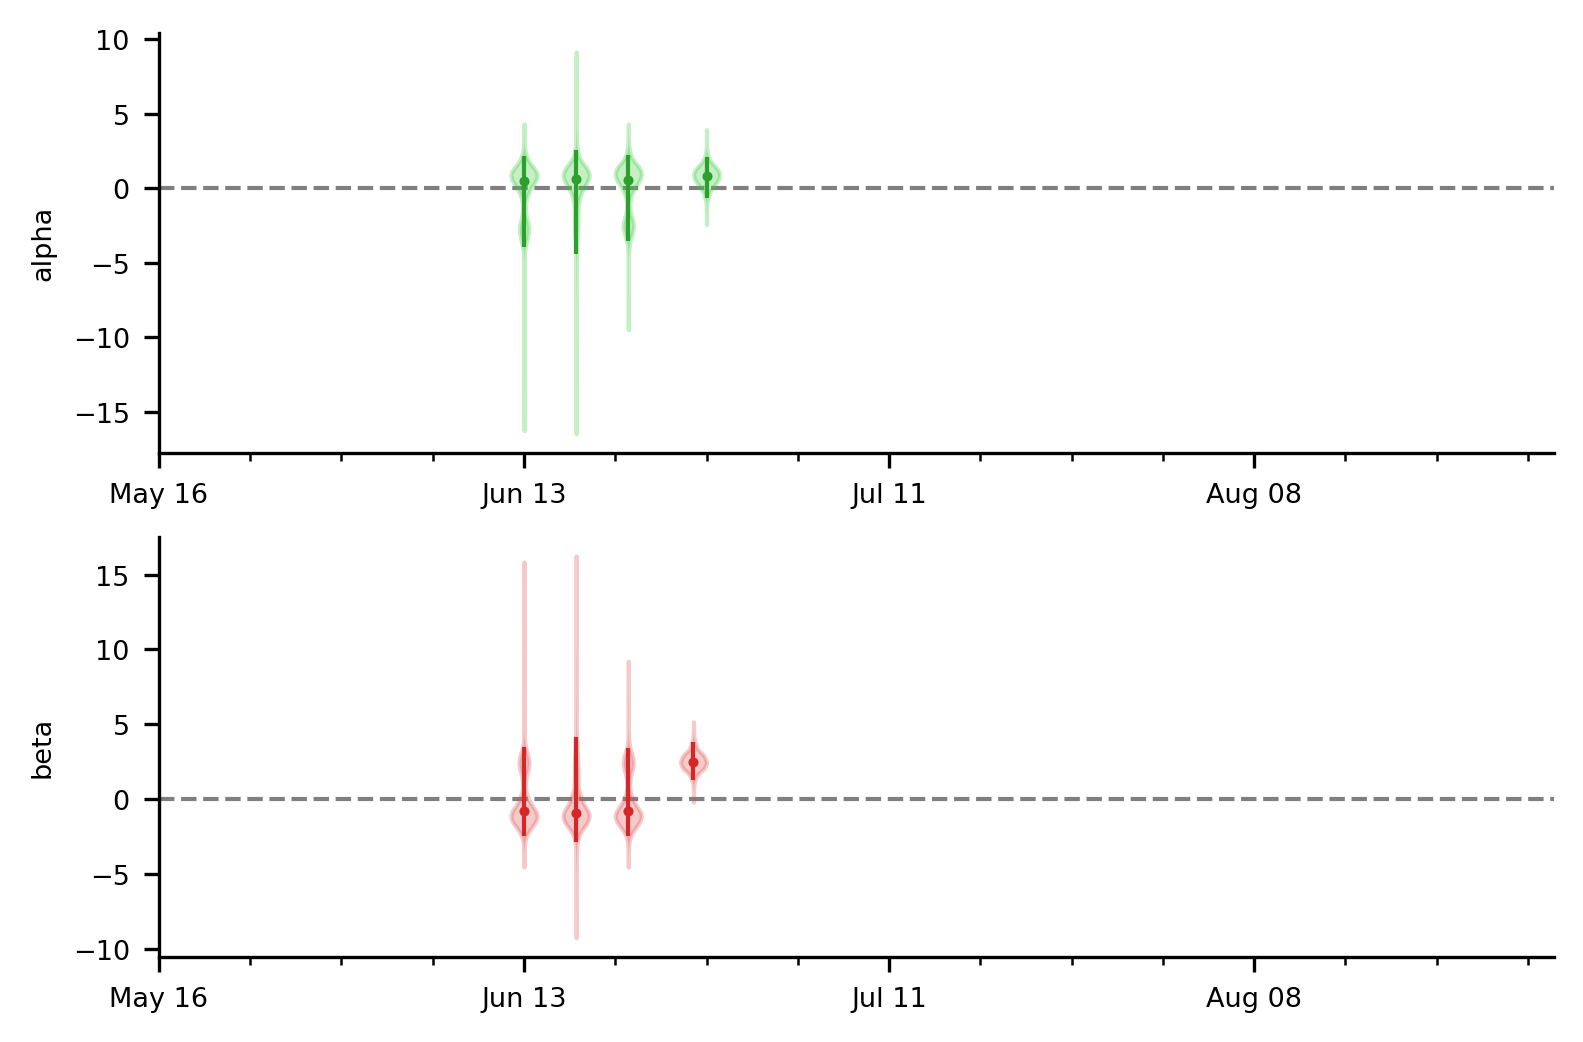

In [9]:
from covid19_soccer.plot.overview import single_extended,single_extended_v2
from covid19_soccer.plot.other import game_effects
from covid19_soccer.plot.utils import format_date_axis
"""
country2ylim_inbalance = {
    "England": [tr_spain,0.3],
    "Scotland": [-0.15,0.45],
    "Slovakia": [-0.6,0.6],
    "Italy": [-0.3,0.45],
    "Czechia": [-0.3,0.45]
}
"""
ylim_Imbalance = [-0.19,0.25]
ylim_Rnoise = [0.9,1.2]
ylim_Rbase = [0.5,2]

for trace,model,dl in zip(traces,models,dls):
    
    country = dl.countries[0]
    if country == "Netherlands":
        ylim_rbase = [-0.5,5]
    else:
        ylim_rbase = ylim_Rbase
    
    if country == "Scotland":
        ylim_imbalance = [-0.19,0.46]
    else:
        ylim_imbalance = ylim_Imbalance
        
    if country == "Italy":
        ylim_incidence=[0,220]
    else:
        ylim_incidence=None
        
    fig0 = single_extended_v2(
        trace,
        model,
        dl,
        ylim_imbalance=ylim_imbalance,
        ylim_incidence=ylim_incidence,
        ylim_rnoise=ylim_Rnoise,
        ylim_rbase=ylim_rbase,
        show_hosted=True
    )
    if country == "Czechia":
        country = "Czech Republic"
    fig0.suptitle(f"{country}")

    fig0.savefig(
        f"../figures/SI/extended_overview/extended_overview_{dl.countries[0]}.pdf",
        transparent=True,
        dpi=300,
        bbox_inches='tight'
    )
    fig0.savefig(
        f"../figures/SI/extended_overview/extended_overview_{dl.countries[0]}.png",
        transparent=True,
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
    plt.close(fig=fig0)

    
    # Plot alpha
    # Plot beta
    fig,axes = plt.subplots(2,1,figsize=(6,4))
    game_effects(
        axes[0],
        trace,
        model,
        dl,
        color="tab:green",
        key="alpha"
    )
    format_date_axis(axes[0])
    axes[0].set_ylabel("alpha")
    game_effects(
        axes[1],
        trace,
        model,
        dl,
        color="tab:red",
        key="beta"
    )
    format_date_axis(axes[1])
    axes[1].set_ylabel("beta")
    axes[0].set_xlim(model.sim_begin, model.sim_end)
    axes[1].set_xlim(model.sim_begin, model.sim_end)
    plt.show()
    plt.close(fig=fig)  
    

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 18 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

pandas           : 1.2.4
covid19_inference: 0.3.6
seaborn          : 0.11.1
numpy            : 1.20.3
sys              : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
matplotlib       : 3.5.1

Watermark: 2.3.1

